# Projeto MTR

0. Pegar o dataset de covid disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import json
from torch import save, load

# Dataset

In [ ]:
seed = 952811309#randint(0, 4294967295)
print(seed)

952811309


In [4]:
df = pd.read_csv('data/covid/hosp1_v8 (1).csv') # 526 exemplos
df2 = pd.read_csv('data/covid/hospital2 (2).csv').drop(columns=['creatino.fosfoquinase.cpk.plasma.ck',
                                                                  'troponina.i.plasma.troponina.i']) # 134 exemplos
df = pd.concat([df, df2])
print('Nº de instâncias:', len(df))
df.head()

Nº de instâncias: 660


sex   age  creatinina.plasma.creatinina  \
0  0.0  67.0                          1.17   
1  0.0  72.0                          0.90   
2  0.0  55.0                          1.02   
3  0.0  58.0                          0.90   
4  0.0  66.0                          1.98   

   dimero.d.plasma.dimeros.d.quantitativo  hemograma.eosinofilos.percentual  \
0                                   233.0                               0.0   
1                                  1475.0                               0.0   
2                                   439.0                               0.0   
3                                   215.0                               0.0   
4                                  1484.0                               0.5   

   hemograma.hemoglobina  hemograma.leucocitos  \
0                   12.5                3730.0   
1                   15.8                6610.0   
2                   14.6                3810.0   
3                   13.9               16190.0   
4                   12.8                4250.0   

   hemograma.linfocitos.percentual  hemograma.monocitos.percentual  \
0                             13.4                            11.3   
1                             20.3                             9.5   
2                             17.6                            12.3   
3                              4.2                             3.2   
4                             33.6                            12.7   

   hemograma.neutrofilos.percentual  hemograma.plaquetas  potassio.potassio  \
0                              75.0             182000.0                4.7   
1                              70.0             144000.0                4.7   
2                              69.8             111000.0                3.7   
3                              92.4             270000.0                4.9   
4                              52.5             135000.0                3.6   

   proteina.c.reativa.plasma.proteina.creativa  sodio.sodio  tgo.ast.tgo  \
0                                         5.86        140.0         77.0   
1                                         6.88        135.0         28.0   
2                                         3.35        137.0         41.0   
3                                         4.84        137.0         14.0   
4                                         7.07        139.0         60.0   

   tpg.alt.tgp  ureia.plasma.ureia  severity  
0        115.0                60.0         1  
1         13.0                39.0         1  
2         38.0                28.0         1  
3         29.0                49.0         1  
4         48.0                53.0         1

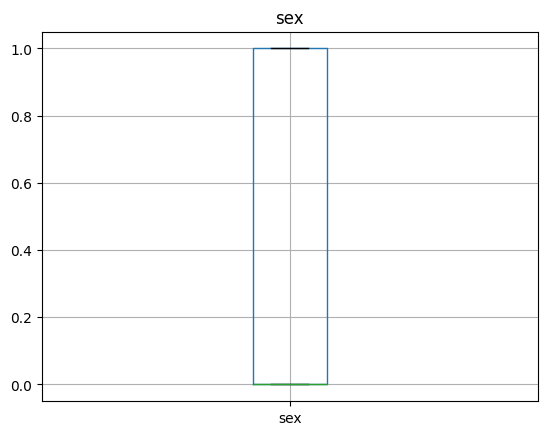

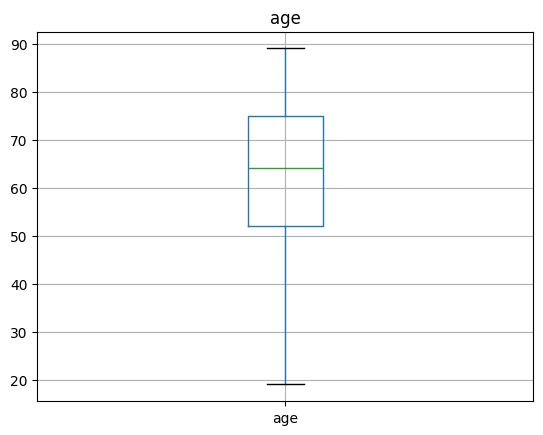

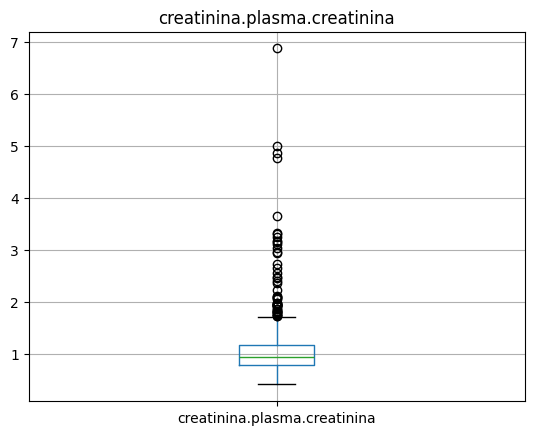

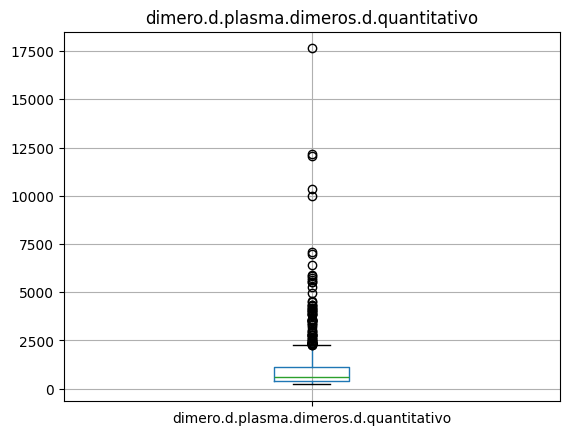

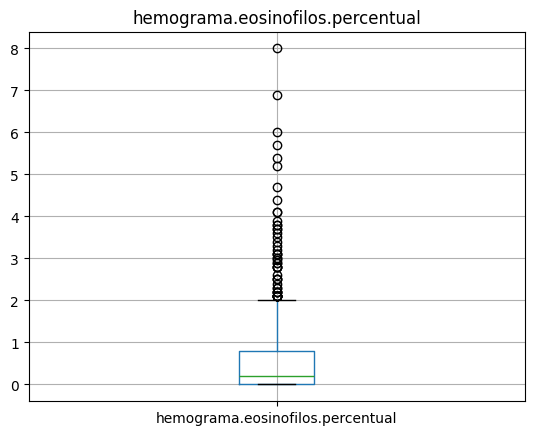

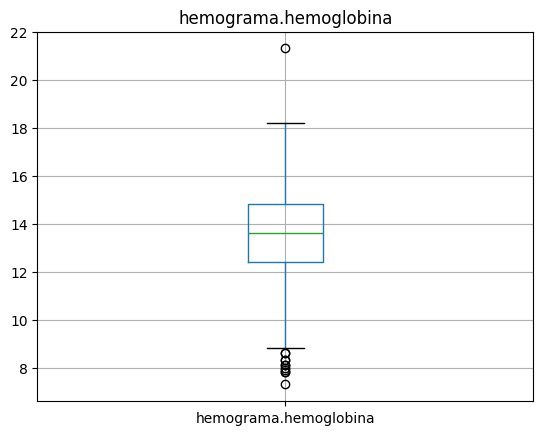

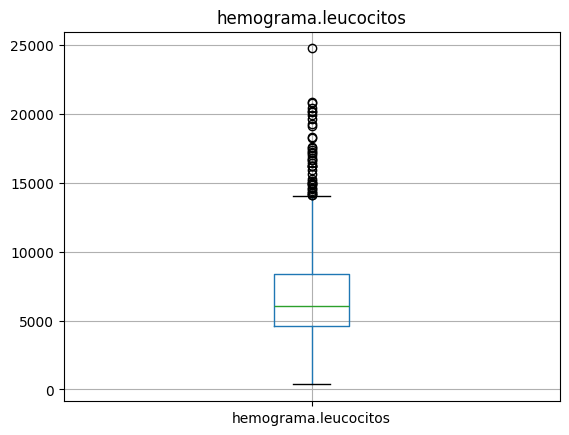

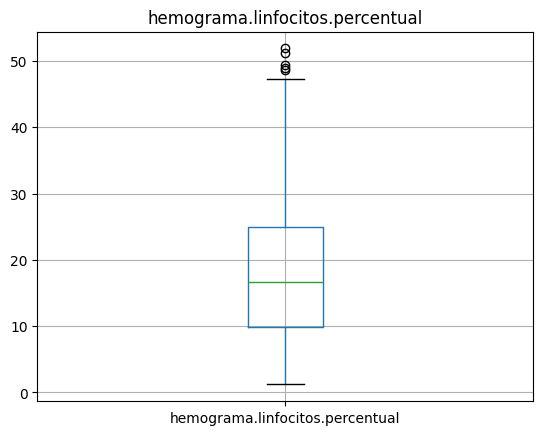

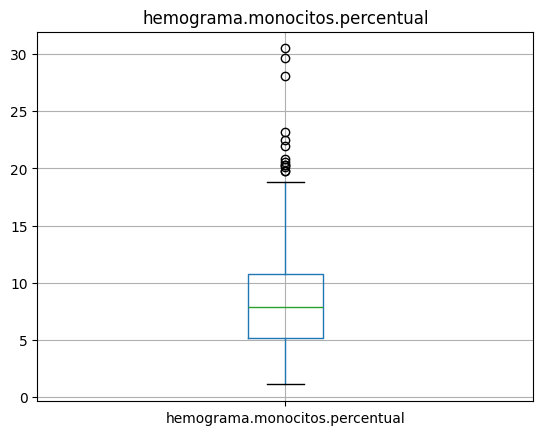

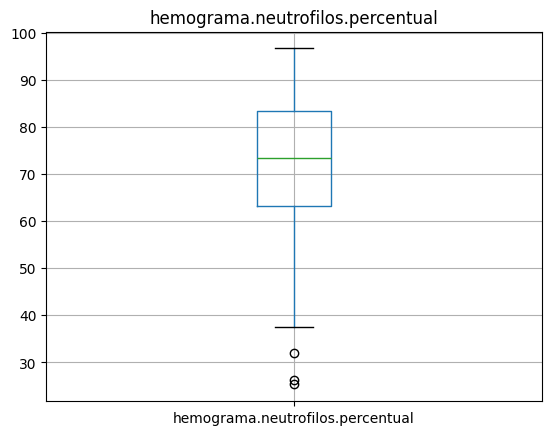

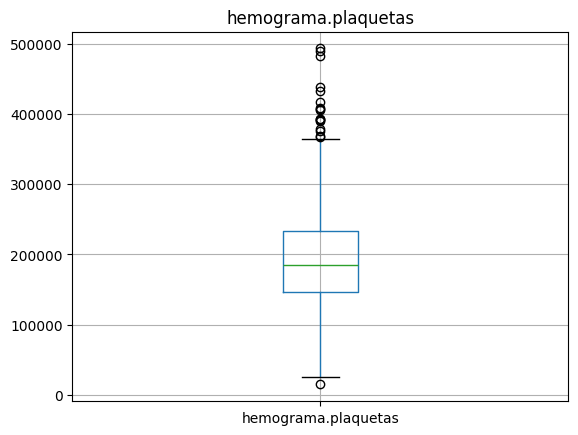

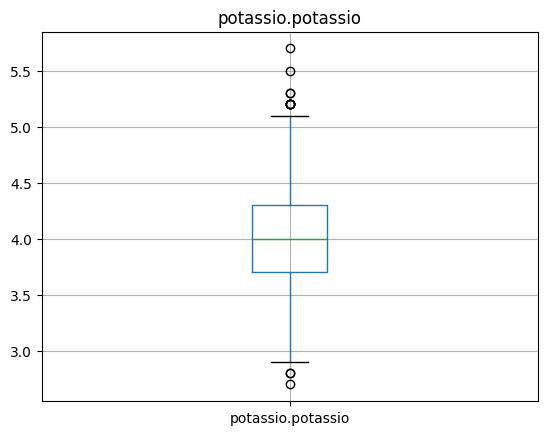

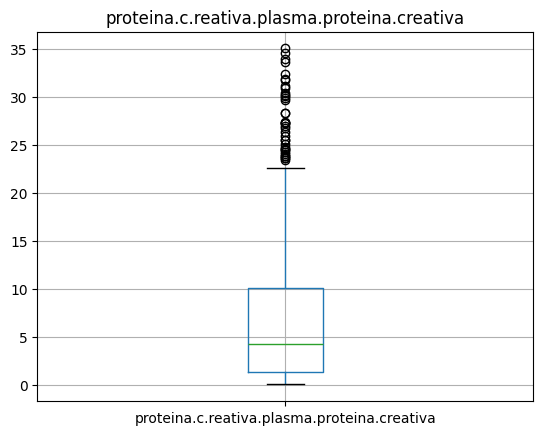

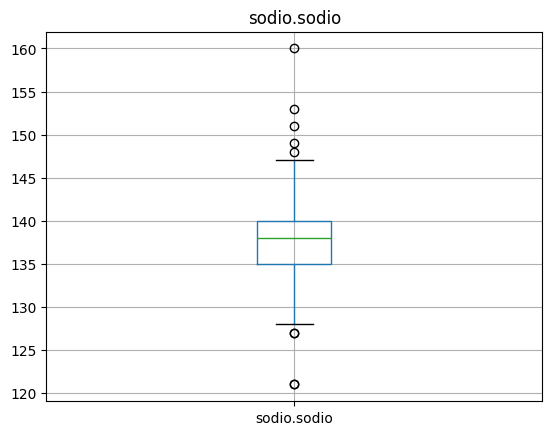

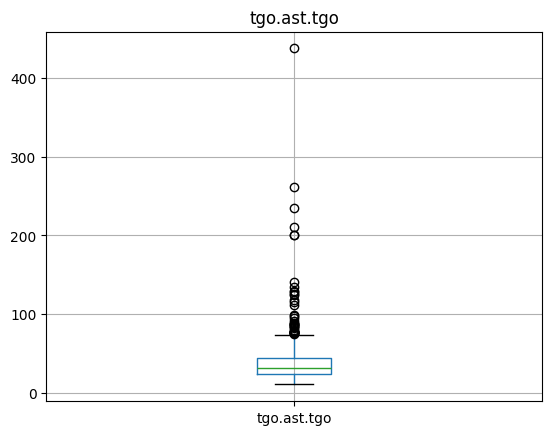

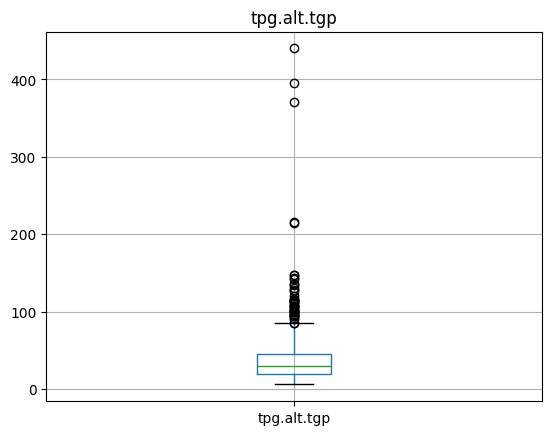

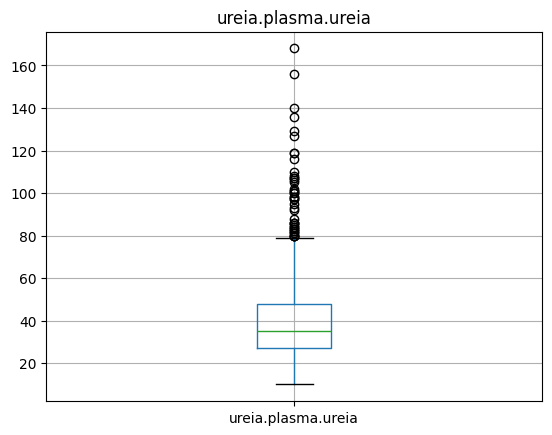

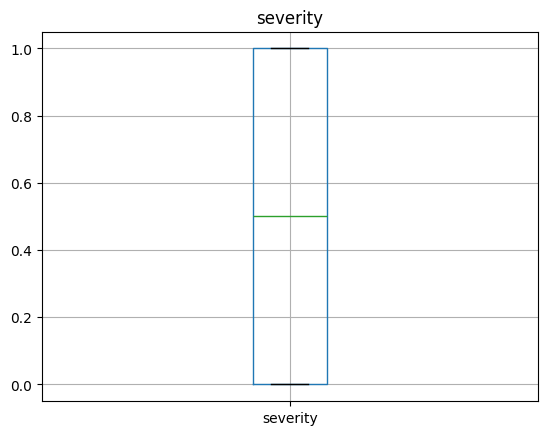

In [5]:
for col in df.columns:
    bp = df[[col]].boxplot()
    plt.title(col)
    plt.show(bp)

In [6]:
# Removing dastric outliers
df = df[(df['tpg.alt.tgp']<200) & (df['tgo.ast.tgo']<200) & (df['sodio.sodio']<155) & (df['dimero.d.plasma.dimeros.d.quantitativo']<7500)]
df

sex   age  creatinina.plasma.creatinina  \
0    0.0  67.0                          1.17   
1    0.0  72.0                          0.90   
2    0.0  55.0                          1.02   
3    0.0  58.0                          0.90   
4    0.0  66.0                          1.98   
..   ...   ...                           ...   
129  1.0  86.0                          0.90   
130  0.0  64.0                          4.77   
131  0.0  60.0                          1.41   
132  0.0  53.0                          1.05   
133  0.0  72.0                          1.66   

     dimero.d.plasma.dimeros.d.quantitativo  hemograma.eosinofilos.percentual  \
0                                     233.0                               0.0   
1                                    1475.0                               0.0   
2                                     439.0                               0.0   
3                                     215.0                               0.0   
4                                    1484.0                               0.5   
..                                      ...                               ...   
129                                  1689.0                               0.3   
130                                  3559.0                               0.0   
131                                  2118.0                               0.2   
132                                   585.0                               0.2   
133                                  2574.0                               0.1   

     hemograma.hemoglobina  hemograma.leucocitos  \
0                     12.5           3730.000000   
1                     15.8           6610.000000   
2                     14.6           3810.000000   
3                     13.9          16190.000000   
4                     12.8           4250.000000   
..                     ...                   ...   
129                    9.8           3930.000000   
130                   11.6           6914.464017   
131                   15.5          10610.000000   
132                   15.6           6130.000000   
133                   10.9          11410.000000   

     hemograma.linfocitos.percentual  hemograma.monocitos.percentual  \
0                               13.4                            11.3   
1                               20.3                             9.5   
2                               17.6                            12.3   
3                                4.2                             3.2   
4                               33.6                            12.7   
..                               ...                             ...   
129                             16.8                             7.9   
130                              2.1                             4.1   
131                              7.9                             5.5   
132                             10.1                             9.0   
133                              2.9                             7.9   

     hemograma.neutrofilos.percentual  hemograma.plaquetas  potassio.potassio  \
0                           75.000000             182000.0           4.700000   
1                           70.000000             144000.0           4.700000   
2                           69.800000             111000.0           3.700000   
3                           92.400000             270000.0           4.900000   
4                           52.500000             135000.0           3.600000   
..                                ...                  ...                ...   
129                         74.700000             176000.0           4.300000   
130                         74.809557             231000.0           4.043257   
131                         85.700000             259000.0           5.000000   
132                         80.500000             190000.0           3.600000   
133                         89.000000             182000.0           4.100

In [7]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5
cols = df.drop(columns=['severity']).columns

temp = df[df.severity==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.severity==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['severity'], train_neg['severity']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [8]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

In [ ]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['severity'], test_neg['severity']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [10]:
performs = {}
models_error = pd.DataFrame()
models = []

In [11]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [12]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 40}


In [13]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8311
Recall:           0.8077
Precision:        0.8235
F1:               0.8155
AUROC:            0.8965
AUPR:             0.8622
1-maxProb média:  0.1689
1-maxProb dp:     0.1216

[Testing]

Accuracy:         0.6195
Recall:           0.5630
Precision:        0.6634
F1:               0.6091
AUROC:            0.6794
AUPR:             0.6734
1-maxProb média:  0.1763
1-maxProb dp:     0.1341


In [14]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.190476
1  0.285714
2  0.190476
3  0.500000
4  0.868421

In [15]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [16]:
sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [17]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.7689
Recall:           0.7212
Precision:        0.7653
F1:               0.7426
AUROC:            0.8090
AUPR:             0.7964
1-maxProb média:  0.2852
1-maxProb dp:     0.1311

[Testing]

Accuracy:         0.6283
Recall:           0.4958
Precision:        0.7108
F1:               0.5842
AUROC:            0.7102
AUPR:             0.7449
1-maxProb média:  0.2954
1-maxProb dp:     0.1328


### Logistic Regression

In [18]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [19]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.7600
Recall:           0.7212
Precision:        0.7500
F1:               0.7353
AUROC:            0.8125
AUPR:             0.8036
1-maxProb média:  0.2924
1-maxProb dp:     0.1253

[Testing]

Accuracy:         0.6416
Recall:           0.5042
Precision:        0.7317
F1:               0.5970
AUROC:            0.7183
AUPR:             0.7609
1-maxProb média:  0.2982
1-maxProb dp:     0.1290


### K-Nearest Neighbors

(KNN)

In [20]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


In [21]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0000
1-maxProb dp:     0.0000

[Testing]

Accuracy:         0.5752
Recall:           0.2773
Precision:        0.7674
F1:               0.4074
AUROC:            0.7360
AUPR:             0.7576
1-maxProb média:  0.3260
1-maxProb dp:     0.1164


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Support Vector Machine - Linear
(SVM)

In [22]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 1}


In [23]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.7644
Recall:           0.7019
Precision:        0.7684
F1:               0.7337
AUROC:            0.8101
AUPR:             0.7862
1-maxProb média:  0.3469
1-maxProb dp:     0.0965

[Testing]

Accuracy:         0.6460
Recall:           0.4790
Precision:        0.7600
F1:               0.5876
AUROC:            0.7136
AUPR:             0.7549
1-maxProb média:  0.3420
1-maxProb dp:     0.0995


### Support Vector Machine - Polynomial
(SVM)

In [24]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 10, 'degree': 3, 'gamma': 'auto'}


In [25]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9422
Recall:           0.8750
Precision:        1.0000
F1:               0.9333
AUROC:            0.9976
AUPR:             0.9974
1-maxProb média:  0.3956
1-maxProb dp:     0.0736

[Testing]

Accuracy:         0.5796
Recall:           0.3866
Precision:        0.6765
F1:               0.4920
AUROC:            0.6695
AUPR:             0.7217
1-maxProb média:  0.3945
1-maxProb dp:     0.0919


### Support Vector Machine - RBF
(SVM)

In [26]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [27]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.8444
Recall:           0.7692
Precision:        0.8791
F1:               0.8205
AUROC:            0.9165
AUPR:             0.9188
1-maxProb média:  0.2748
1-maxProb dp:     0.0985

[Testing]

Accuracy:         0.6770
Recall:           0.5798
Precision:        0.7500
F1:               0.6540
AUROC:            0.7316
AUPR:             0.7430
1-maxProb média:  0.3137
1-maxProb dp:     0.1069


### Multi-Layer Perceptron
(MLP)

In [28]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.8356
Recall:           0.7981
Precision:        0.8384
F1:               0.8177
AUROC:            0.9094
AUPR:             0.9096
1-maxProb média:  0.2392
1-maxProb dp:     0.1429

[Testing]

Accuracy:         0.6726
Recall:           0.5630
Precision:        0.7528
F1:               0.6442
AUROC:            0.7354
AUPR:             0.7733
1-maxProb média:  0.2509
1-maxProb dp:     0.1514


### Kolmogorov-Arnold Network
(KAN)

In [90]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [93]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]
INP_SIZE = Xb_train_norm.shape[1]
kan_params = {'width': [[INP_SIZE,2,2,2], [INP_SIZE,3,2], [INP_SIZE,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/covid.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/covid.pkl')
    save(kanet.state_dict(), 'kan_params/covid.pt')
else:
    with open('kan_params/covid.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/covid.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

| train_loss: 8.23e-01 | test_loss: 8.23e-01 | reg: 6.23e+00 | : 100%|█| 15/15 [00:04<00:00,  3.16it
| train_loss: 7.08e-01 | test_loss: 7.08e-01 | reg: 1.20e+01 | : 100%|█| 15/15 [00:04<00:00,  3.69it
| train_loss: 8.31e-01 | test_loss: 8.31e-01 | reg: 3.15e+00 | : 100%|█| 15/15 [00:04<00:00,  3.61it
| train_loss: 8.31e-01 | test_loss: 8.31e-01 | reg: 2.97e+00 | : 100%|█| 15/15 [00:04<00:00,  3.48it
| train_loss: 8.31e-01 | test_loss: 8.31e-01 | reg: 2.99e+00 | : 100%|█| 15/15 [00:04<00:00,  3.64it
| train_loss: 8.34e-01 | test_loss: 8.34e-01 | reg: 1.92e+00 | : 100%|█| 15/15 [00:04<00:00,  3.45it
| train_loss: 8.35e-01 | test_loss: 8.35e-01 | reg: 2.21e+00 | : 100%|█| 15/15 [00:04<00:00,  3.38it
| train_loss: 8.34e-01 | test_loss: 8.34e-01 | reg: 2.49e+00 | : 100%|█| 15/15 [00:04<00:00,  3.43it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.02e+00 | : 100%|█| 15/15 [00:04<00:00,  3.36it
| train_loss: 8.34e-01 | test_loss: 8.34e-01 | reg: 2.25e+00 | : 100%|█| 15/15 [00:04<00:00

width: [[17, 0], [20, 0], [2, 0]],
grid: 8,
lr: 0.001,
lamb: 0.005


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         0.9333
Recall:           0.9135
Precision:        0.9406
F1:               0.9268
AUROC:            0.9817
AUPR:             0.9823
1-maxProb média:  0.1291
1-maxProb dp:     0.1387

[Testing]

Accuracy:         0.6195
Recall:           0.6387
Precision:        0.6387
F1:               0.6387
AUROC:            0.6907
AUPR:             0.7246
1-maxProb média:  0.1446
1-maxProb dp:     0.1464


### Random Forest

In [33]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}


In [34]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.8178
Recall:           0.7788
Precision:        0.8182
F1:               0.7980
AUROC:            0.8887
AUPR:             0.8750
1-maxProb média:  0.3204
1-maxProb dp:     0.0978

[Testing]

Accuracy:         0.6416
Recall:           0.5462
Precision:        0.7065
F1:               0.6161
AUROC:            0.7311
AUPR:             0.7514
1-maxProb média:  0.3436
1-maxProb dp:     0.0991


### Gradient Boosting

In [35]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 50}


In [36]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9467
Recall:           0.9327
Precision:        0.9510
F1:               0.9417
AUROC:            0.9928
AUPR:             0.9916
1-maxProb média:  0.2264
1-maxProb dp:     0.1151

[Testing]

Accuracy:         0.6416
Recall:           0.5378
Precision:        0.7111
F1:               0.6124
AUROC:            0.7150
AUPR:             0.7649
1-maxProb média:  0.2825
1-maxProb dp:     0.1183


### AdaBoost

In [ ]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
               'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.05, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [38]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8178
Recall:           0.7212
Precision:        0.8621
F1:               0.7853
AUROC:            0.9063
AUPR:             0.9054
1-maxProb média:  0.4533
1-maxProb dp:     0.0407

[Testing]

Accuracy:         0.6549
Recall:           0.5462
Precision:        0.7303
F1:               0.6250
AUROC:            0.7361
AUPR:             0.7522
1-maxProb média:  0.4607
1-maxProb dp:     0.0310


### XGBoost

In [39]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}


In [40]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0972
1-maxProb dp:     0.0605

[Testing]

Accuracy:         0.6283
Recall:           0.5042
Precision:        0.7059
F1:               0.5882
AUROC:            0.7172
AUPR:             0.7449
1-maxProb média:  0.2128
1-maxProb dp:     0.1406


## Análise de Correlações

In [41]:
groups = {}
model_names = list(performs.keys())

In [95]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


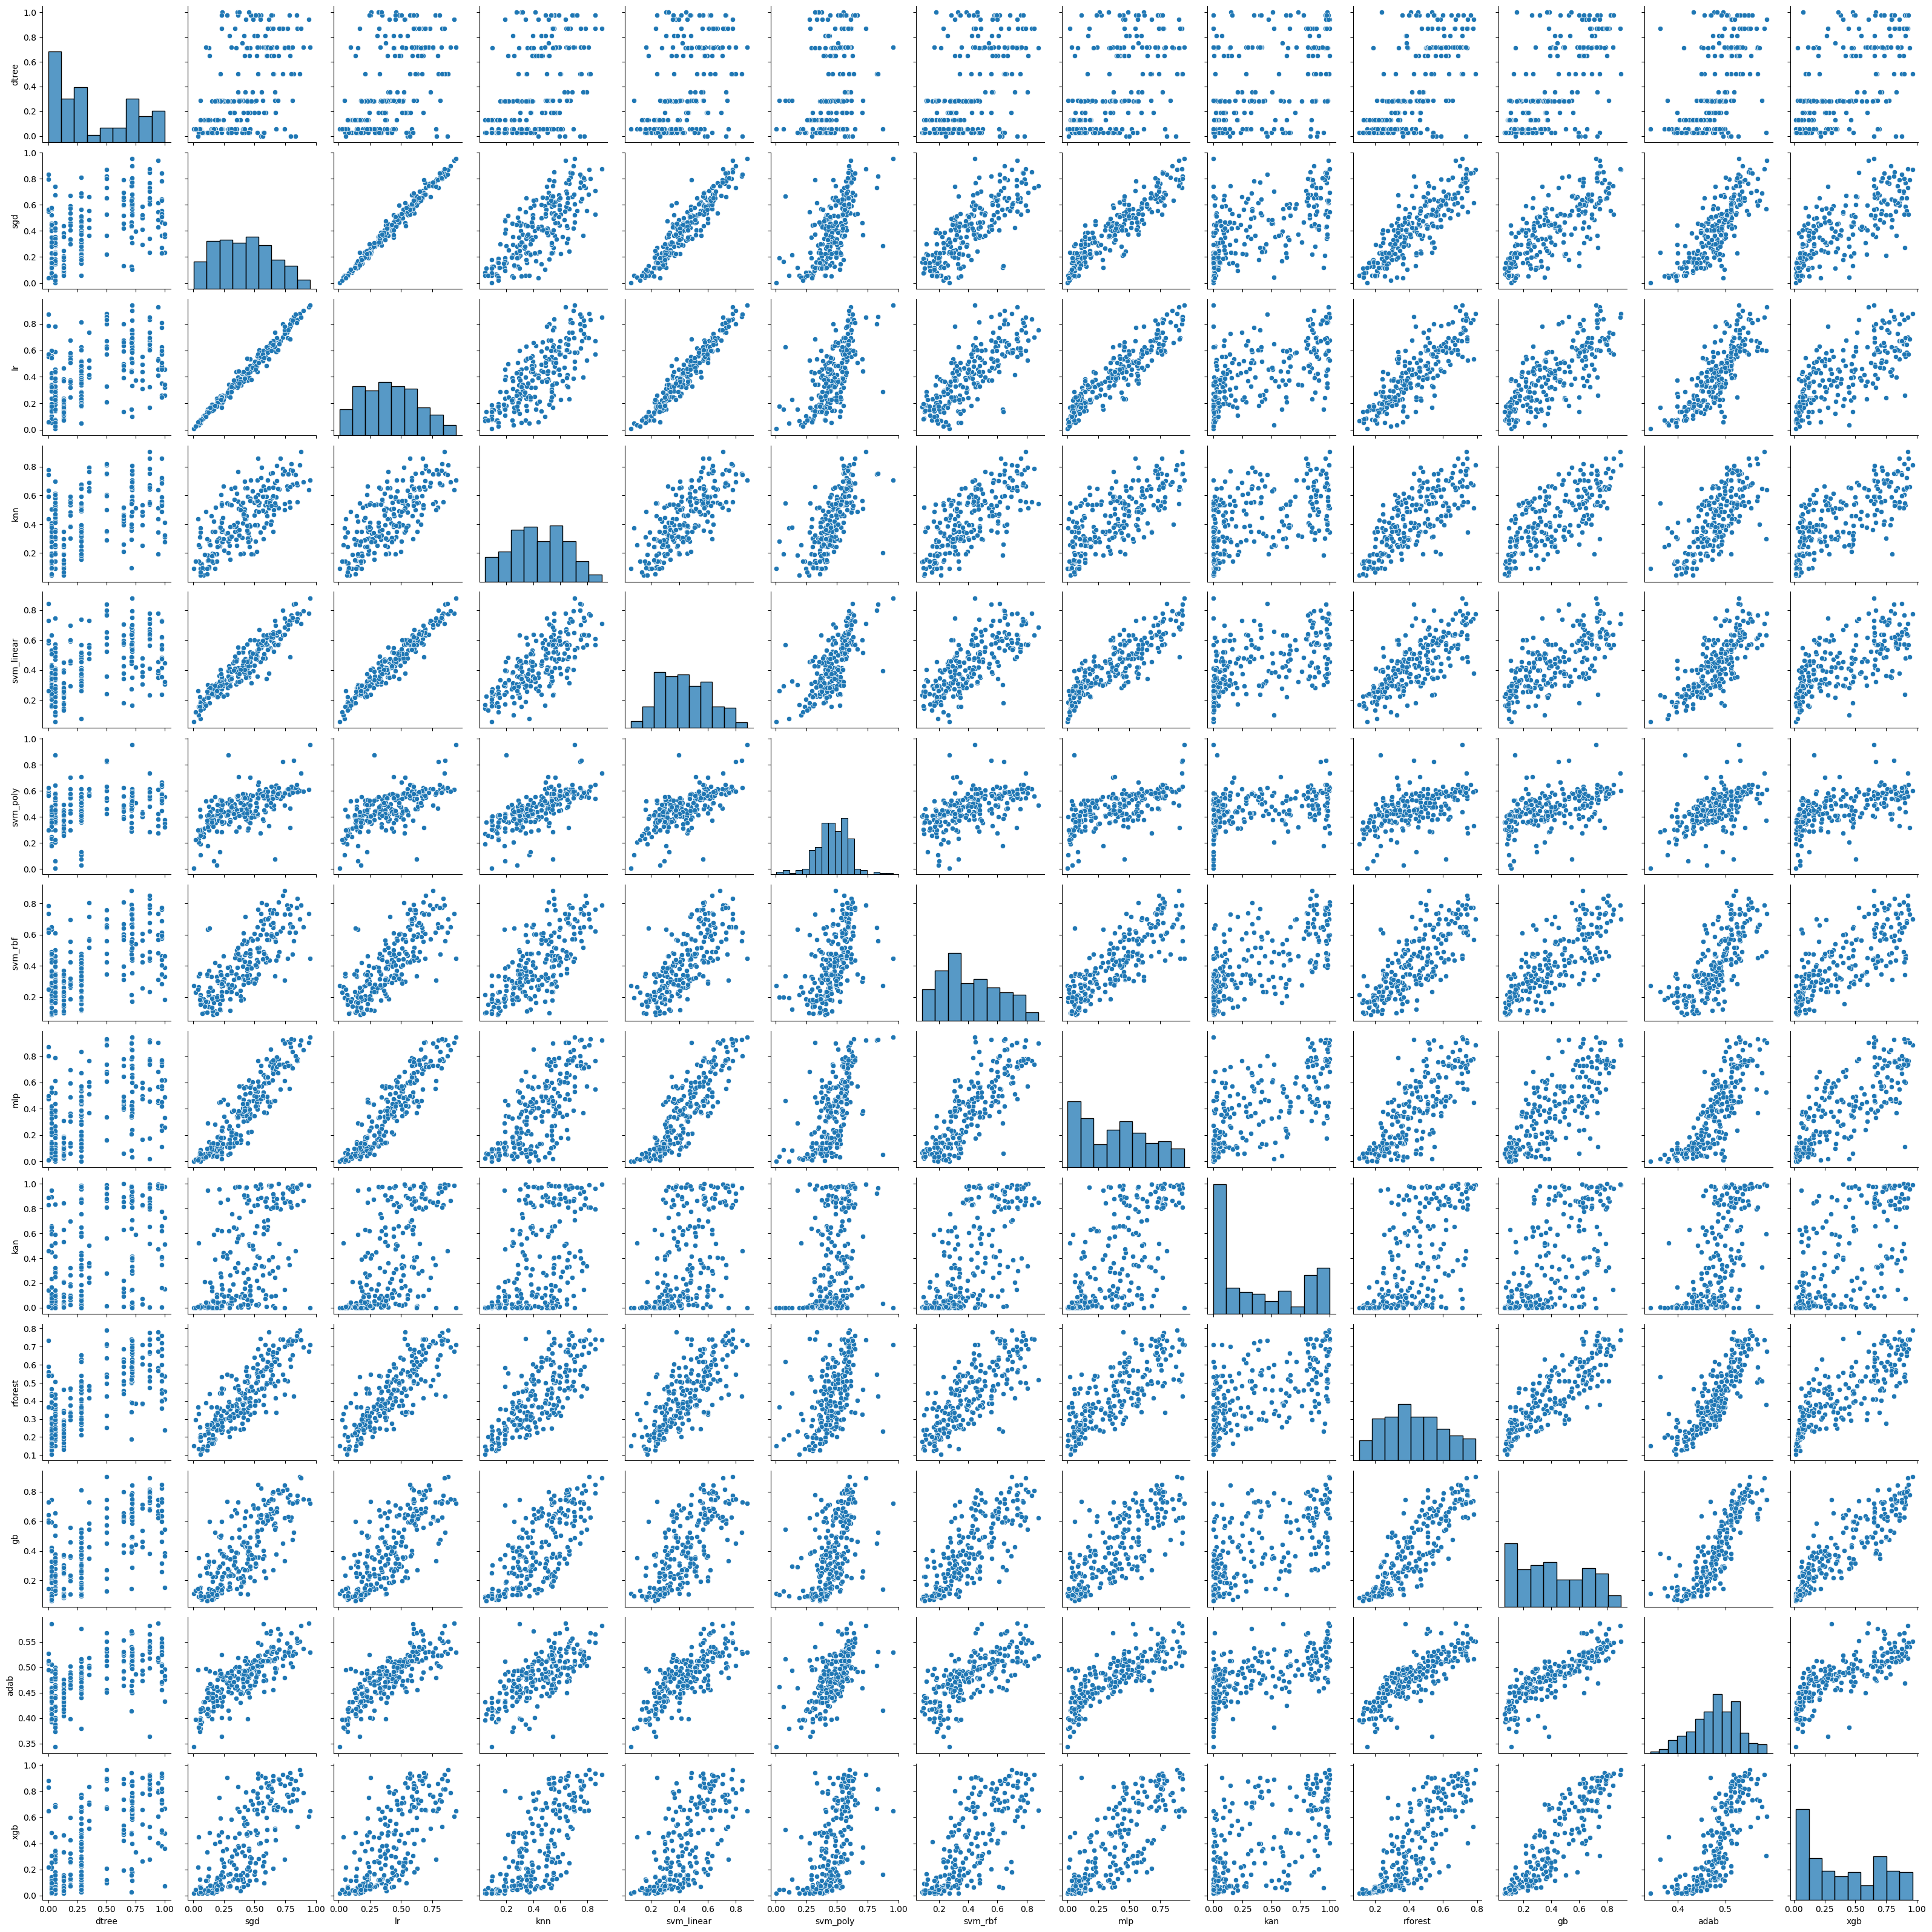

In [96]:
sns.pairplot(models_error)
plt.show()

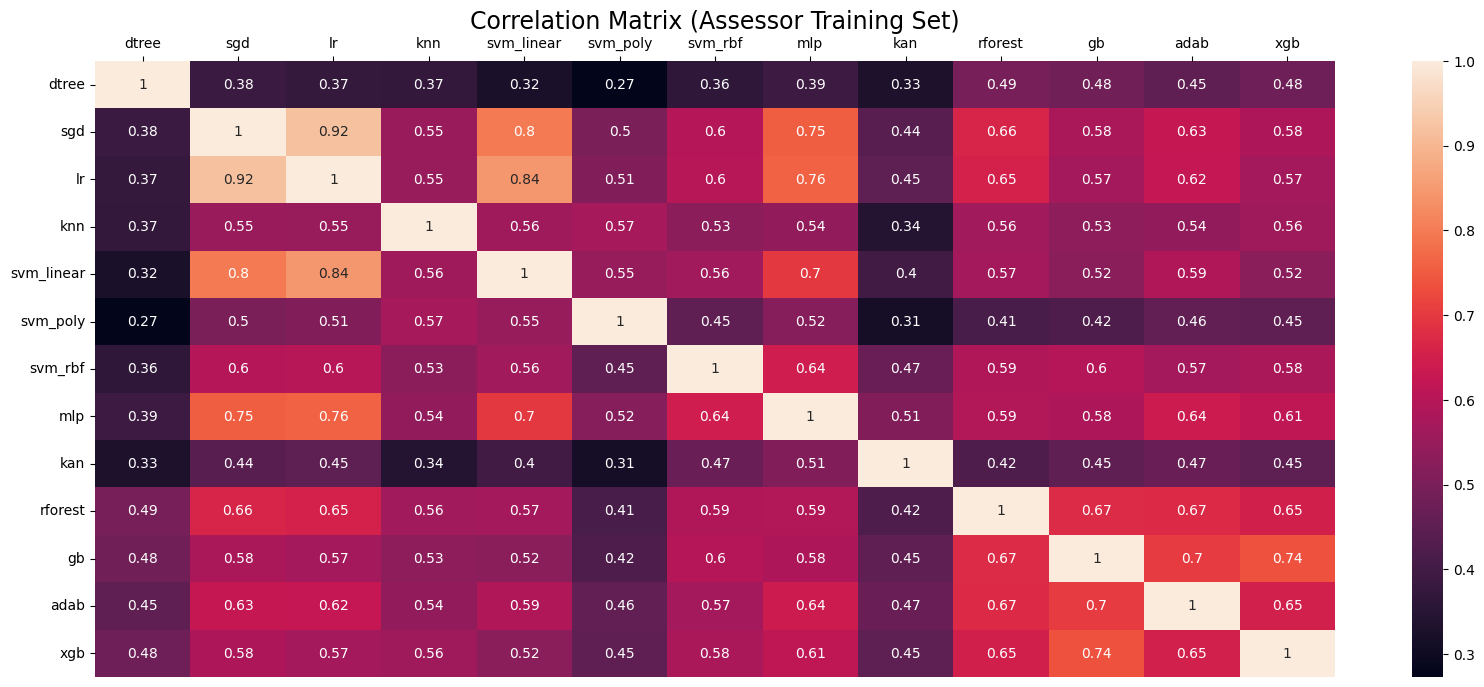

            corr
count  78.000000
mean    0.542366
std     0.123981
min     0.273123
25%     0.454701
50%     0.551583
75%     0.600936
max     0.918112


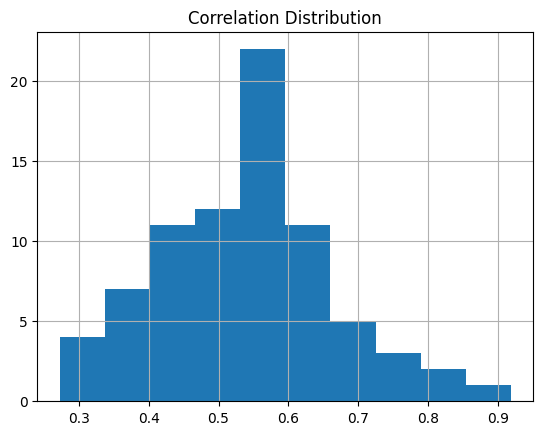

[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [97]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [109]:
MIN_SCORE = 0.645 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.645


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['adab', 'gb', 'rforest', 'xgb']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [114]:
Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.190476  0.326211  0.317721  0.385279    0.447217  0.448780  0.261395   
1  0.285714  0.244484  0.230082  0.665772    0.316237  0.514166  0.463834   
2  0.190476  0.592933  0.552197  0.485749    0.598992  0.616811  0.425044   
3  0.500000  0.869155  0.875341  0.813637    0.776030  0.601459  0.699032   
4  0.868421  0.631041  0.615283  0.752580    0.605284  0.552642  0.738871   

        mlp       kan   rforest        gb      adab       xgb  
0  0.114766  0.189937  0.329469  0.236571  0.468321  0.119452  
1  0.470305  0.441541  0.466102  0.377075  0.479857  0.247849  
2  0.594399  0.103896  0.337260  0.216889  0.474662  0.322782  
3  0.884389  0.991030  0.790703  0.900912  0.551558  0.964818  
4  0.757483  0.798998  0.569722  0.686374  0.533533  0.830849

In [115]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['severity']]

ya_test_tgt = ya_test['severity']
ya_test = ya_test.drop(columns=['severity'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.190476  0.285953  0.354128  0.396356    0.485046  0.518594  0.228260   
1  0.057143  0.232606  0.235379  0.411203    0.361948  0.492017  0.336863   
2  0.717949  0.412710  0.357899  0.568290    0.394412  0.523740  0.500000   
3  0.868421  0.719079  0.665740  0.857670    0.599440  0.558994  0.811594   
4  0.190476  0.527024  0.517484  0.676954    0.549655  0.554389  0.526307   

        mlp       kan   rforest        gb      adab       xgb  
0  0.223247  0.000489  0.218551  0.190790  0.456058  0.030216  
1  0.109068  0.081058  0.242400  0.260972  0.460753  0.086179  
2  0.295608  0.032182  0.650053  0.494326  0.511796  0.653103  
3  0.839491  0.950252  0.780465  0.861225  0.552613  0.968887  
4  0.578856  0.144380  0.451283  0.206187  0.483876  0.161942

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

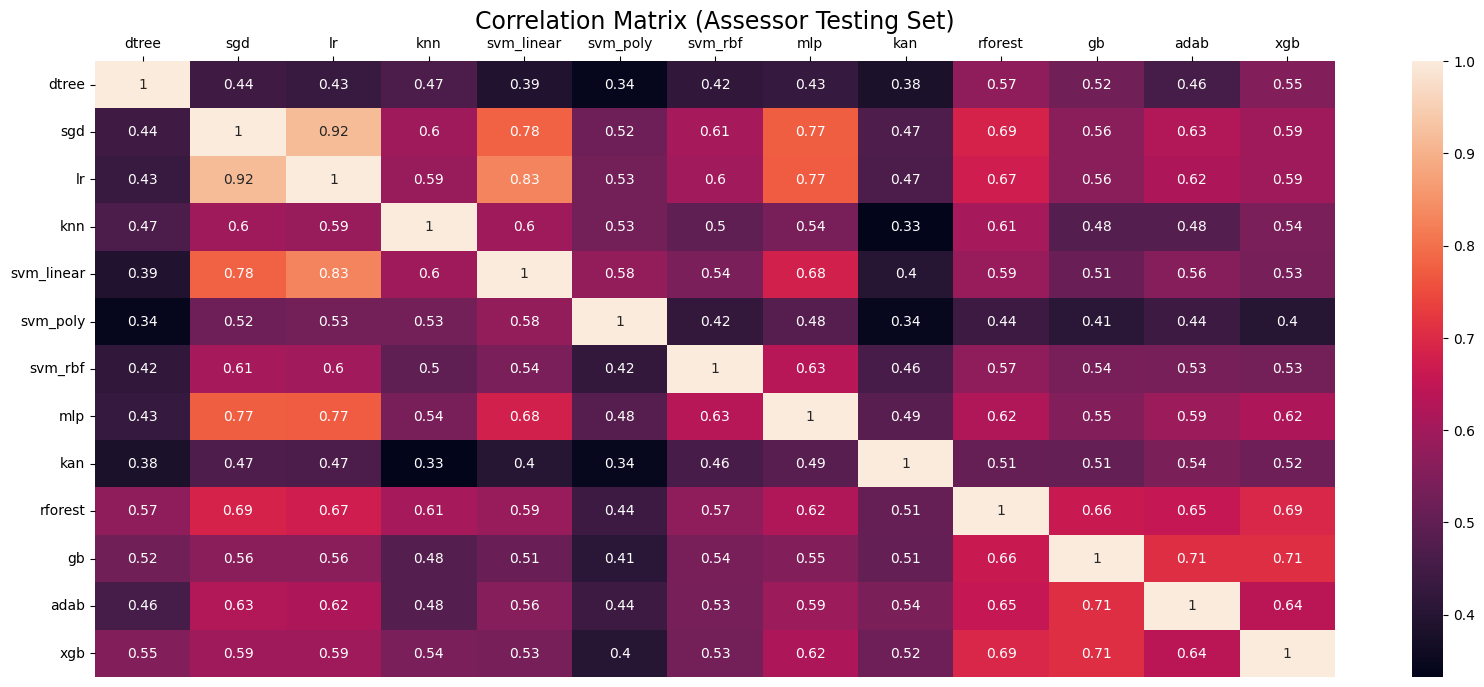

count    78.000000
mean      0.551061
std       0.113178
min       0.332382
25%       0.472271
50%       0.538456
75%       0.606660
max       0.916257
Name: corr, dtype: float64


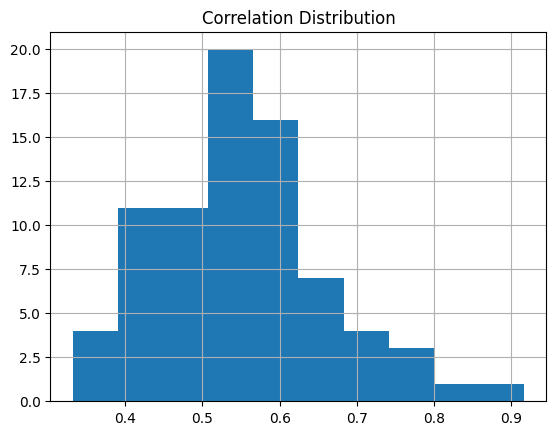

[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [116]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [117]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['adab', 'gb', 'rforest'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0015
NMSE: 0.0383
MAE: 0.0308
NMSE: 0.0955
Desvio Padrão: 0.0376


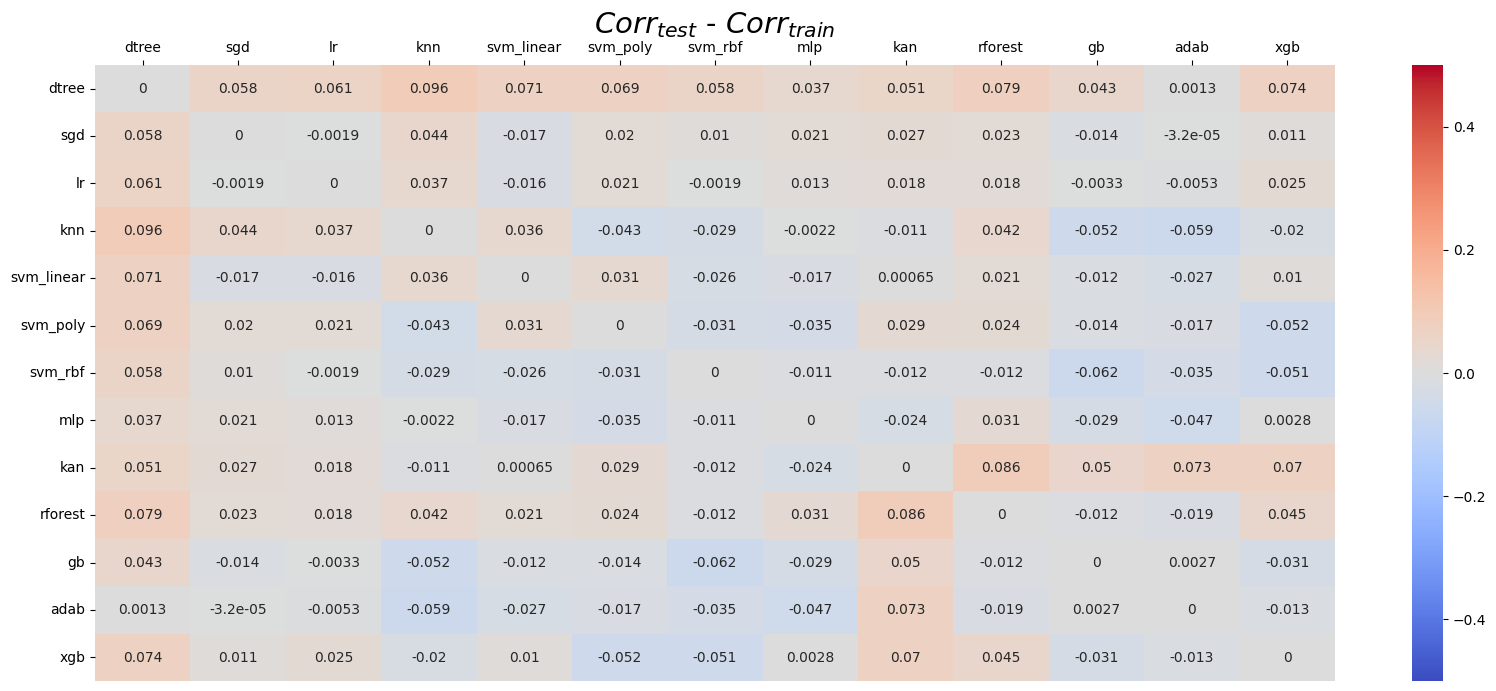

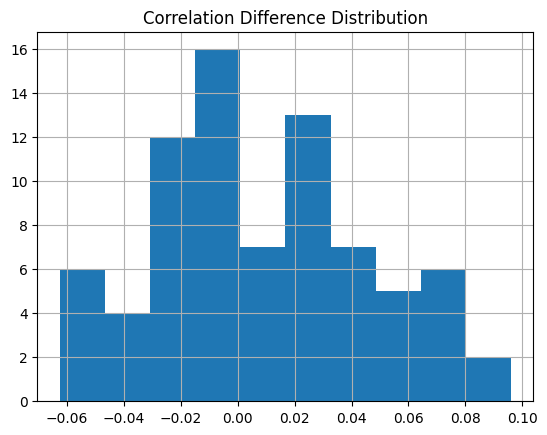

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [118]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

## Globais

### Regressor Chain
(RC)

In [119]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.2s
[Chain] .................. (2 of 13) Processing order 1, total=   0.2s
[Chain] .................. (3 of 13) Processing order 2, total=   0.2s
[Chain] .................. (4 of 13) Processing order 3, total=   0.2s
[Chain] .................. (5 of 13) Processing order 4, total=   0.2s
[Chain] .................. (6 of 13) Processing order 5, total=   0.3s
[Chain] .................. (7 of 13) Processing order 6, total=   0.2s
[Chain] .................. (8 of 13) Processing order 7, total=   0.2s
[Chain] .................. (9 of 13) Processing order 8, total=   0.2s
[Chain] ................. (10 of 13) Processing order 9, total=   0.2s
[Chain] ................ (11 of 13) Processing order 10, total=   0.2s
[Chain] ................ (12 of 13) Processing order 11, total=   0.3s
[Chain] ................ (13 of 13) Processing order 12, total=   0.3s


In [120]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [121]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0577
RMSE: 0.2246
MAE: 0.1876


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.10278  0.054437  0.049001  0.037969     0.02829  0.015932   
multi-output      NaN       NaN       NaN       NaN         NaN       NaN   
individual        NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.043465  0.068808  0.154218  0.033069  0.059668  0.002471   
multi-output       NaN       NaN       NaN       NaN       NaN       NaN   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.100189  
multi-output       NaN  
individual         NaN

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

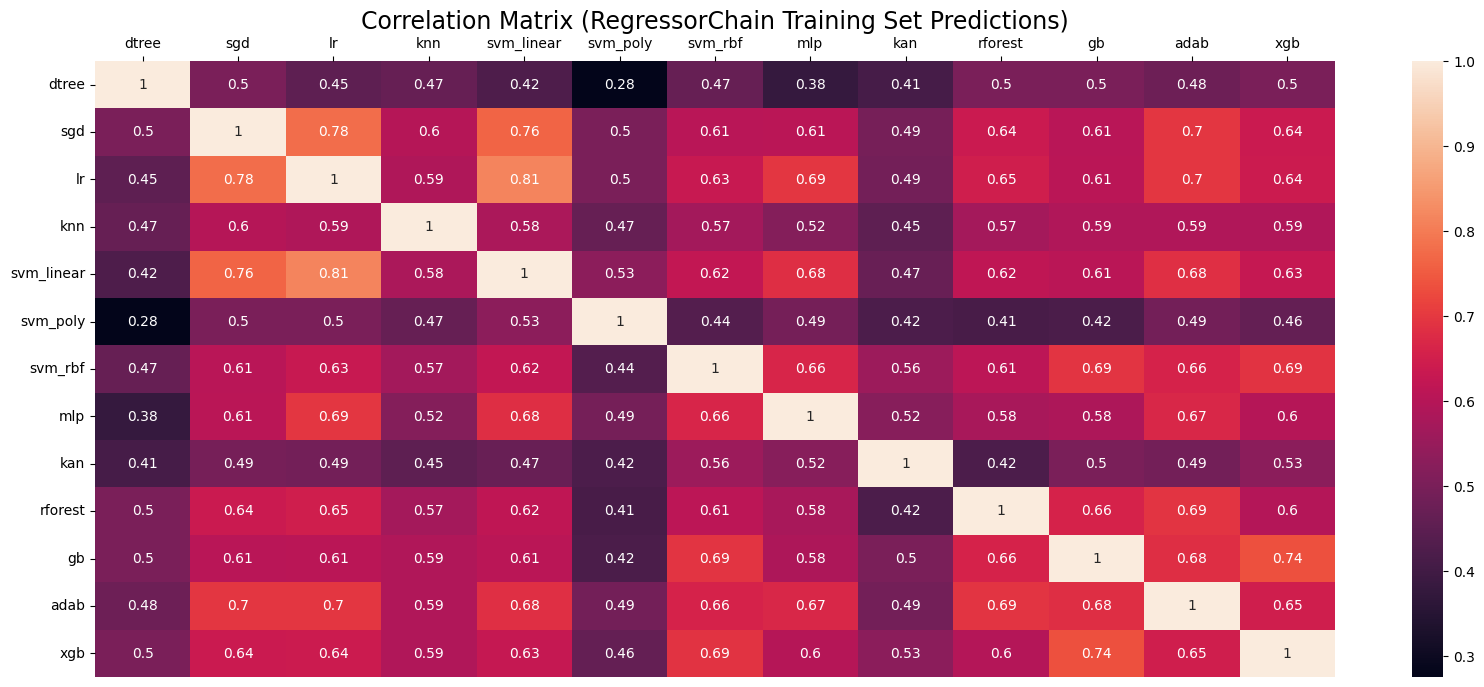

count    78.000000
mean      0.567595
std       0.103690
min       0.275516
25%       0.490069
50%       0.586195
75%       0.639292
max       0.813255
Name: corr, dtype: float64


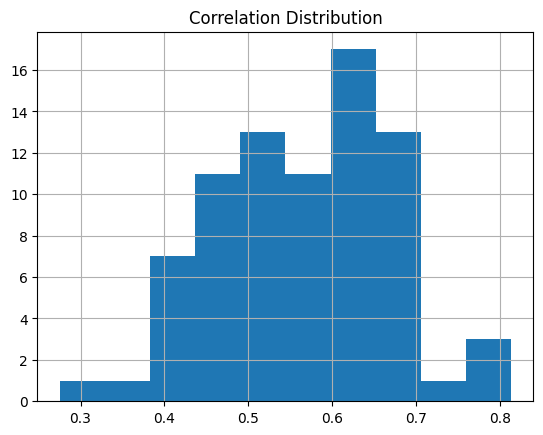

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [122]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('kendall') 

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [123]:
groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

[['dtree'],
 ['adab', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'mlp', 'svm_linear'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly'],
 ['adab', 'mlp', 'svm_rbf'],
 ['adab', 'gb', 'svm_rbf', 'xgb'],
 ['kan'],
 ['adab', 'gb', 'rforest']]

Conjunto de Teste:

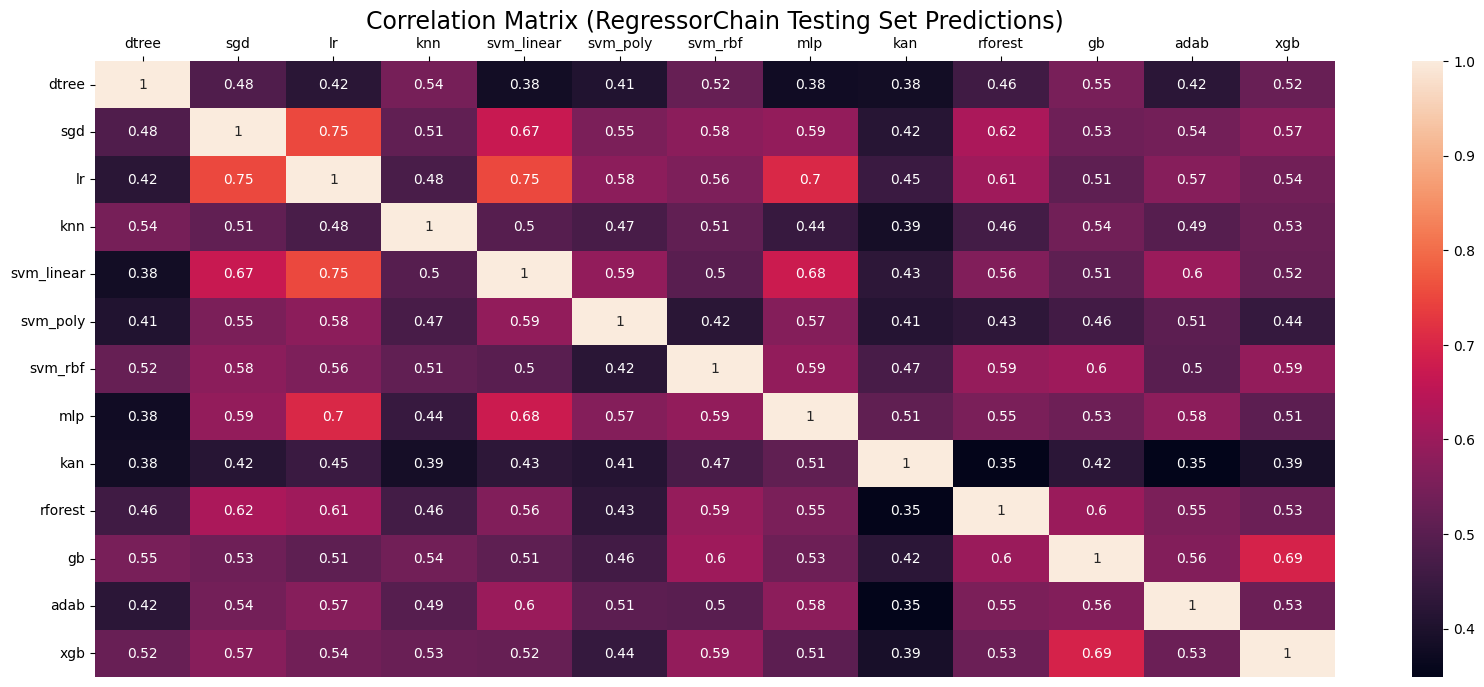

count    78.000000
mean      0.519340
std       0.087323
min       0.348982
25%       0.460613
50%       0.522337
75%       0.571663
max       0.751203
Name: corr, dtype: float64


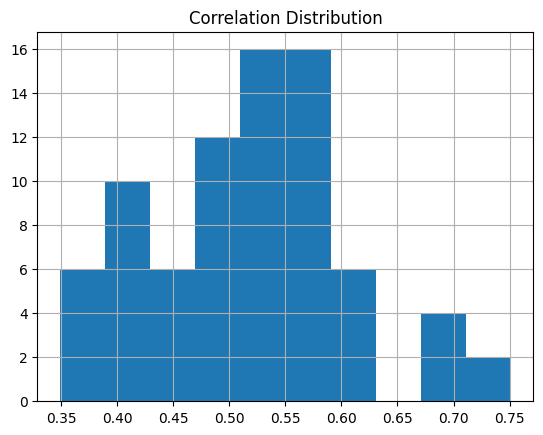

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [124]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [125]:
groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

[['dtree'],
 ['lr', 'sgd', 'svm_linear'],
 ['lr', 'mlp', 'svm_linear'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['rforest'],
 ['gb', 'xgb'],
 ['adab']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0057
RMSE: 0.0755
MAE: 0.0599
NMSE: 0.4445
Desvio Padrão: 0.0689


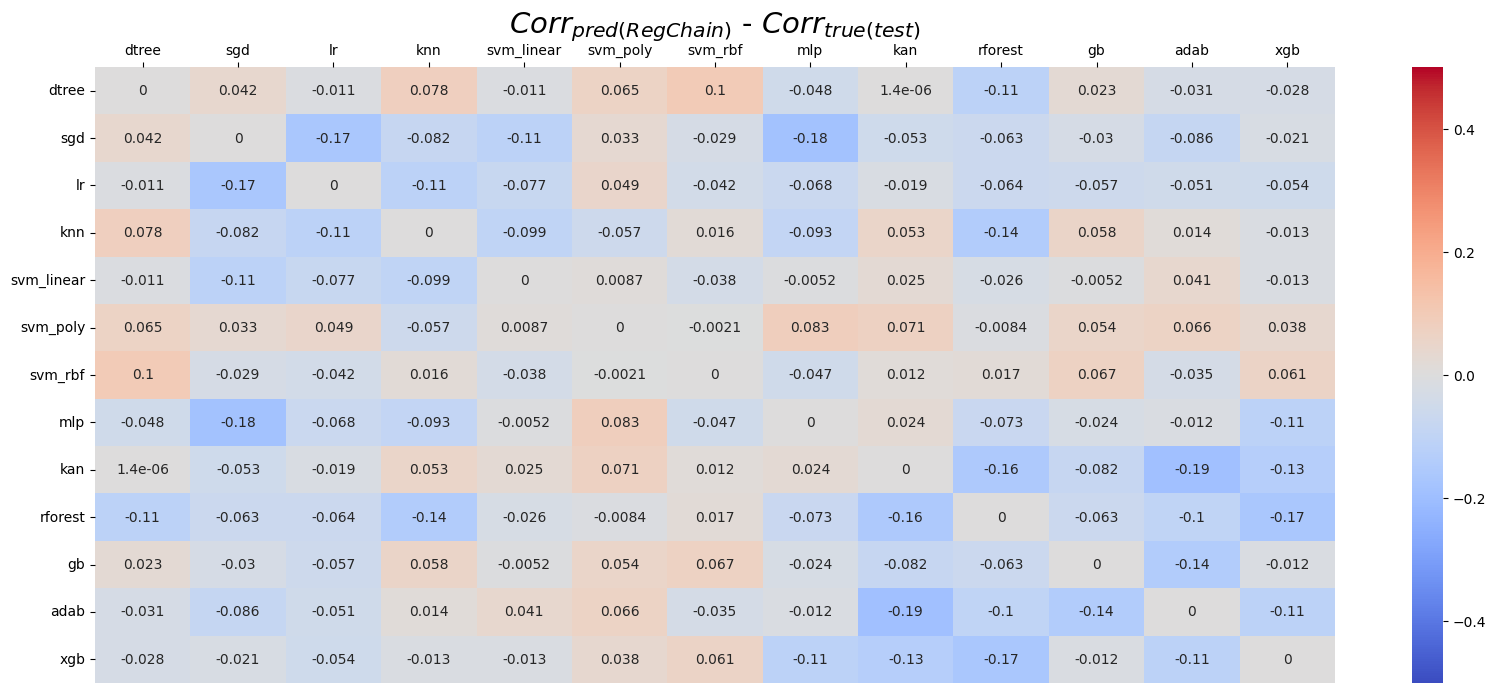

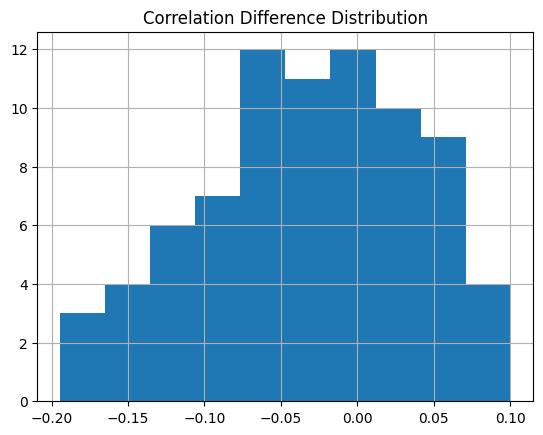

[Saved image "cmd_rc.eps"]
[Saved image "cd_rc.eps"]


In [126]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

### Multi-Output Random Forest Regressor 

In [ ]:
mrf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train)

In [ ]:
ya_pred = mrf.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-rforest',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-rforest',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-rforest',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-rforest',:] = mae_models(ya_test, ya_pred)
mse_df

#### Análise das correlações

Conjunto de Treinamento:

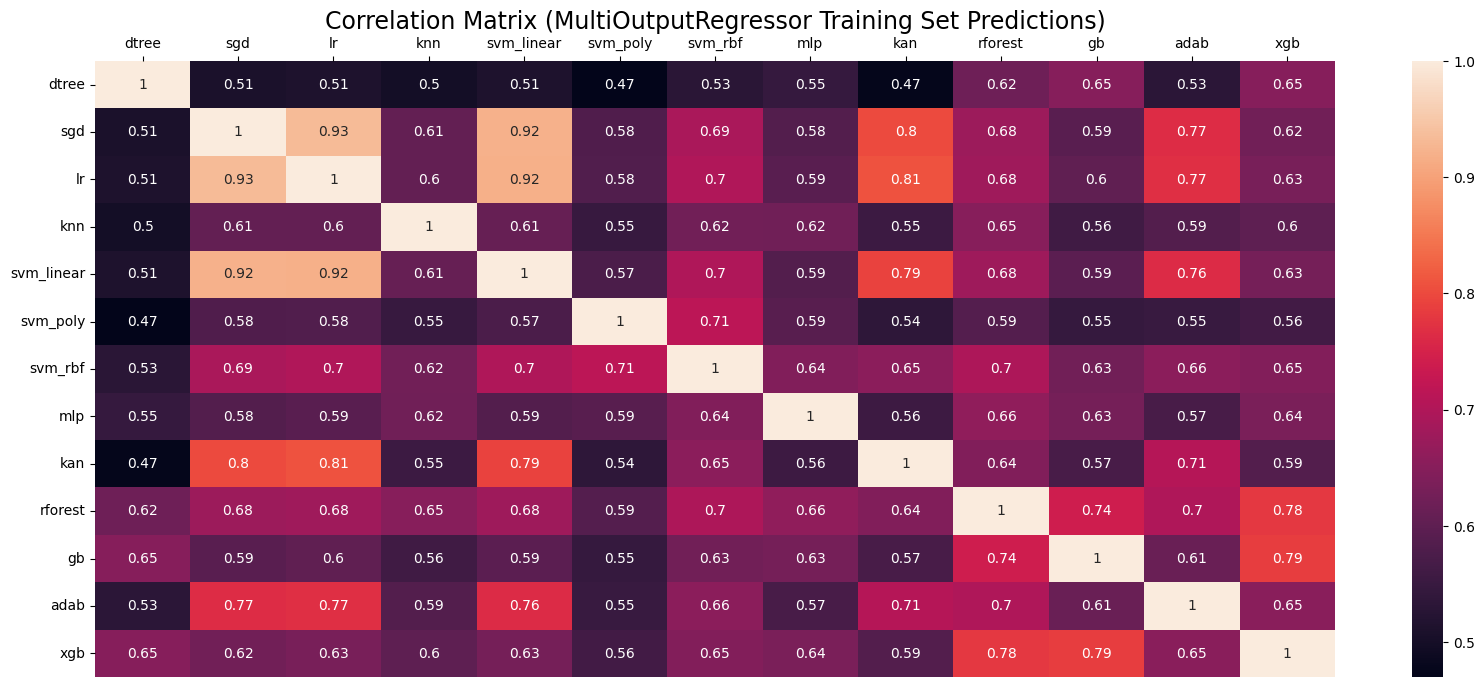

count    78.000000
mean      0.636948
std       0.097030
min       0.470079
25%       0.575778
50%       0.623564
75%       0.679801
max       0.933086
Name: corr, dtype: float64


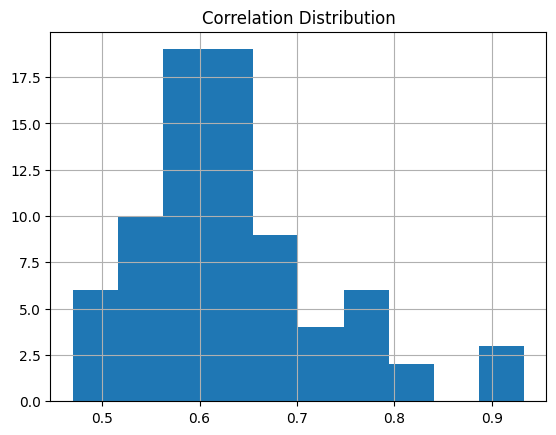

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [ ]:
mrf_corrls = pd.DataFrame(mrf.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [ ]:
groups['mrf_assessor_train'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_train']

[['dtree'],
 ['lr', 'rforest', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'rforest', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

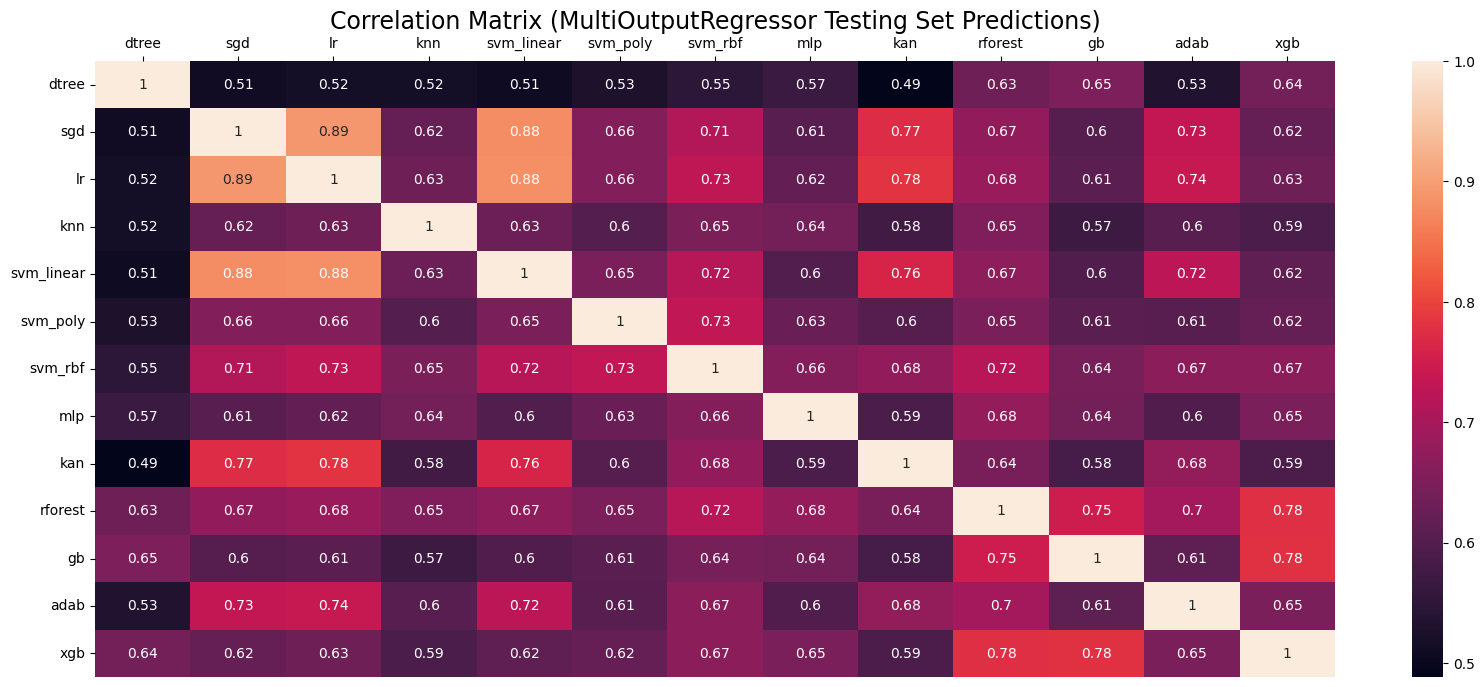

count    78.000000
mean      0.649017
std       0.081683
min       0.488549
25%       0.602560
50%       0.639660
75%       0.678956
max       0.891127
Name: corr, dtype: float64


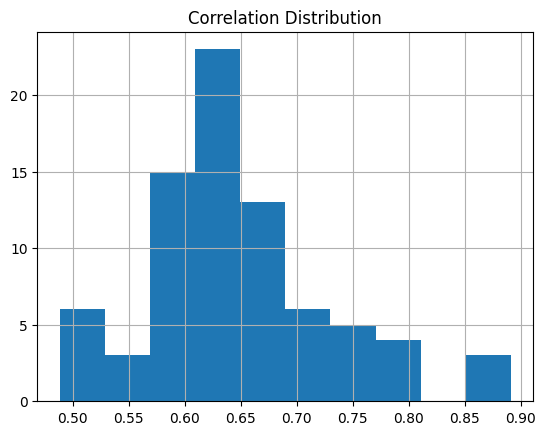

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [ ]:
mrf_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [ ]:
groups['mrf_assessor_test'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_test']

[['dtree'],
 ['kan', 'lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_rbf'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'rforest'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0124
RMSE: 0.1116
MAE: 0.0983
NMSE: 0.6700
Desvio Padrão: 0.0634


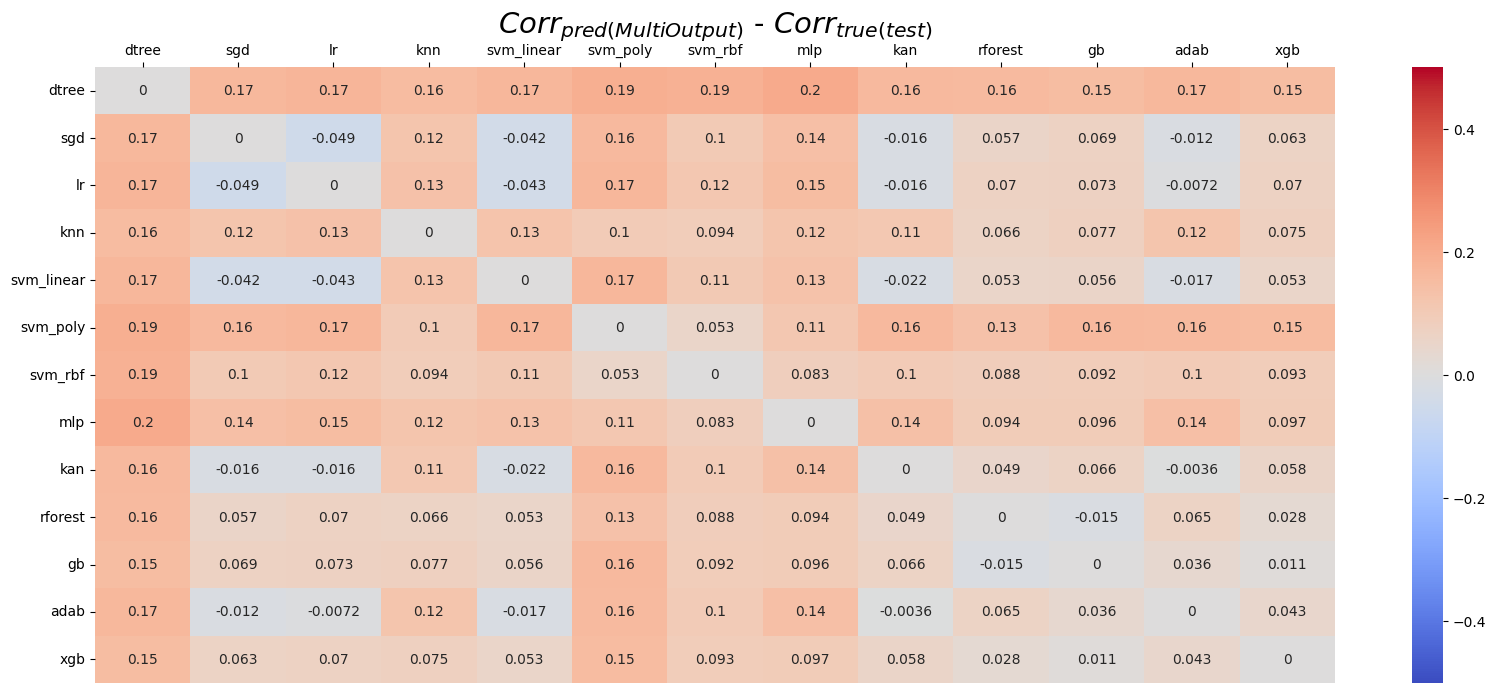

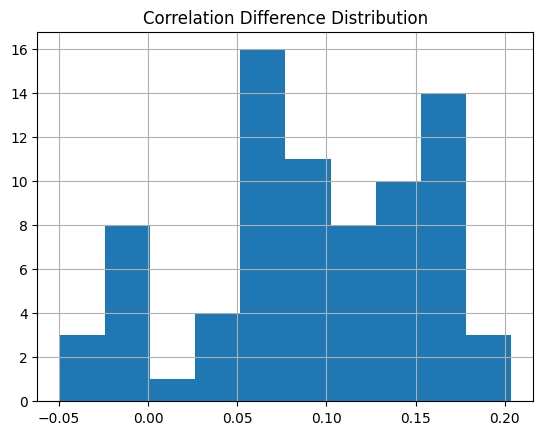

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [ ]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mrf_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandomForest)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

### Multi-Output Regressor 
(ST)

In [127]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [128]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0572
RMSE: 0.2236
MAE: 0.1873


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.10278  0.054437  0.049001  0.037969    0.028290  0.015932   
multi-output  0.10278  0.051025  0.048075  0.036667    0.028684  0.016634   
individual        NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.043465  0.068808  0.154218  0.033069  0.059668  0.002471   
multi-output  0.044201  0.068327  0.152492  0.031263  0.060466  0.002374   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.100189  
multi-output  0.100638  
individual         NaN

#### Análise das correlações

Conjunto de Treinamento:

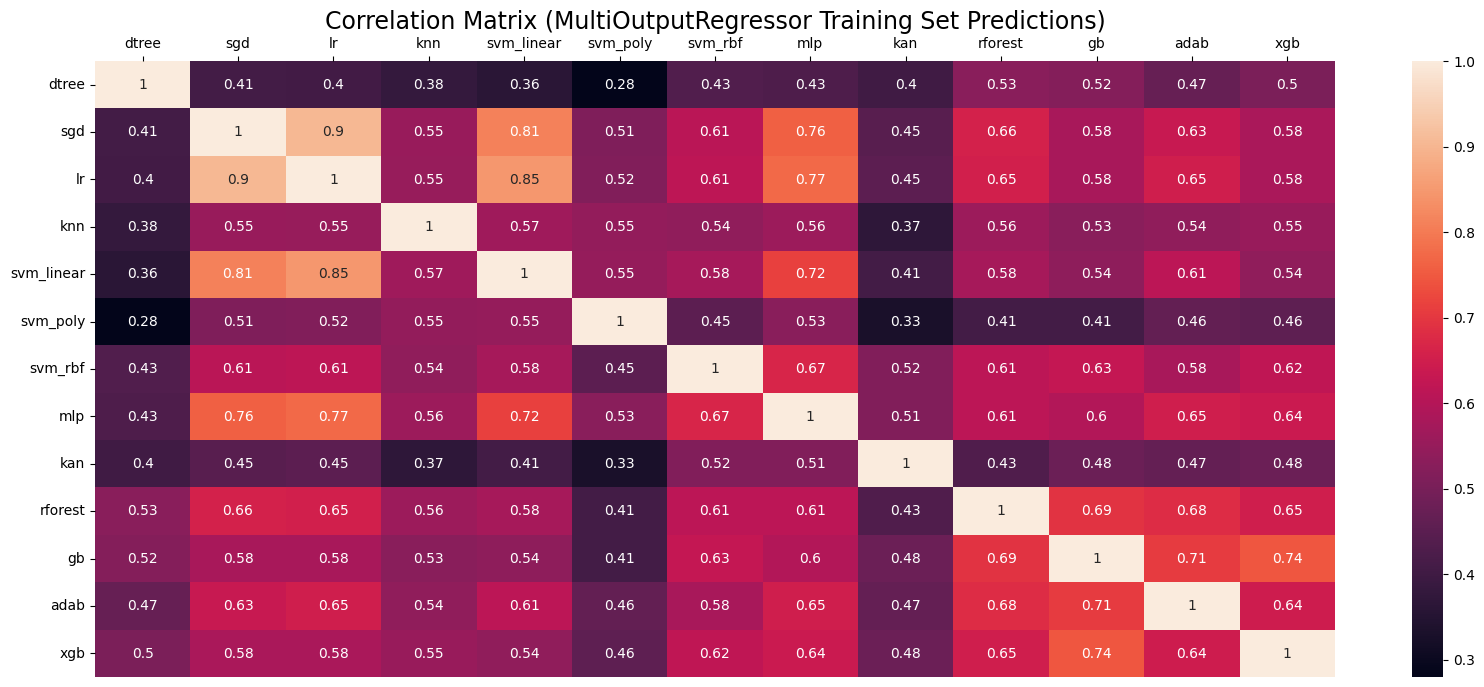

count    78.000000
mean      0.555092
std       0.119151
min       0.279685
25%       0.466391
50%       0.552999
75%       0.625506
max       0.904267
Name: corr, dtype: float64


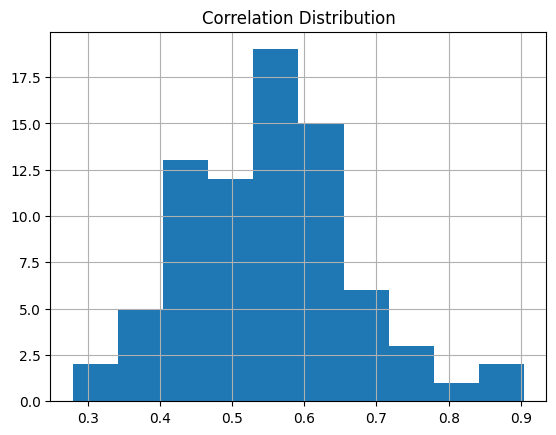

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [129]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [130]:
groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd'],
 ['adab', 'lr', 'mlp'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly'],
 ['mlp', 'svm_rbf'],
 ['kan'],
 ['adab', 'gb', 'rforest'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

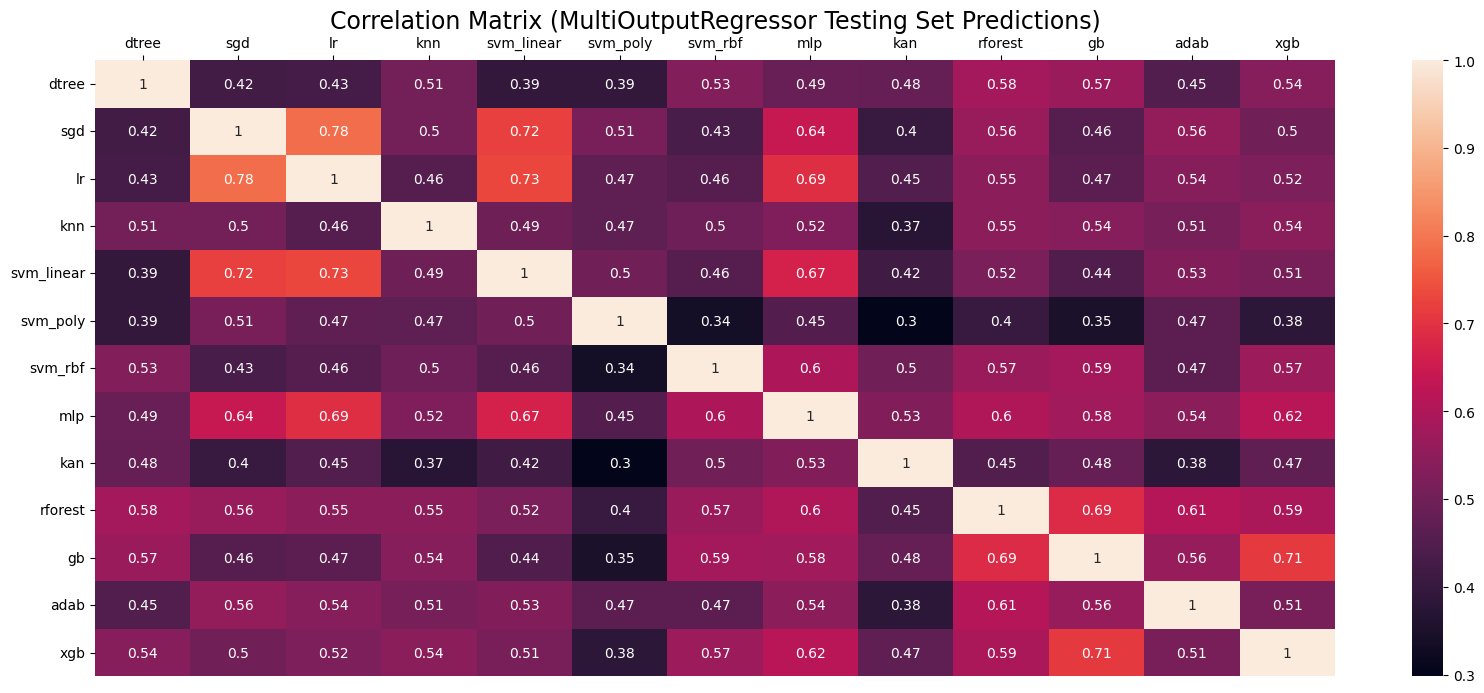

count    78.000000
mean      0.513012
std       0.093689
min       0.298017
25%       0.456754
50%       0.507798
75%       0.563918
max       0.784298
Name: corr, dtype: float64


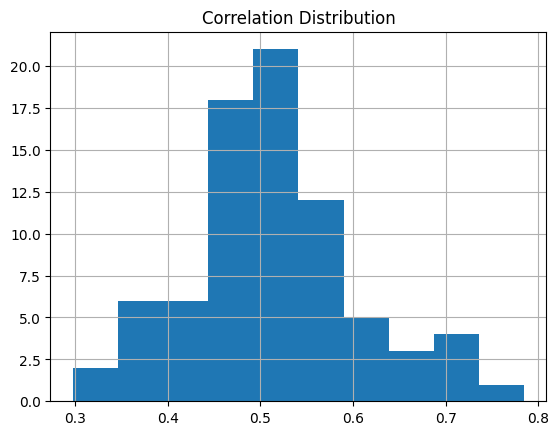

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [131]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

In [132]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['dtree'],
 ['lr', 'sgd', 'svm_linear'],
 ['lr', 'mlp', 'svm_linear'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['gb', 'rforest'],
 ['gb', 'xgb'],
 ['adab']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0053
RMSE: 0.0727
MAE: 0.0590
NMSE: 0.4129
Desvio Padrão: 0.0624


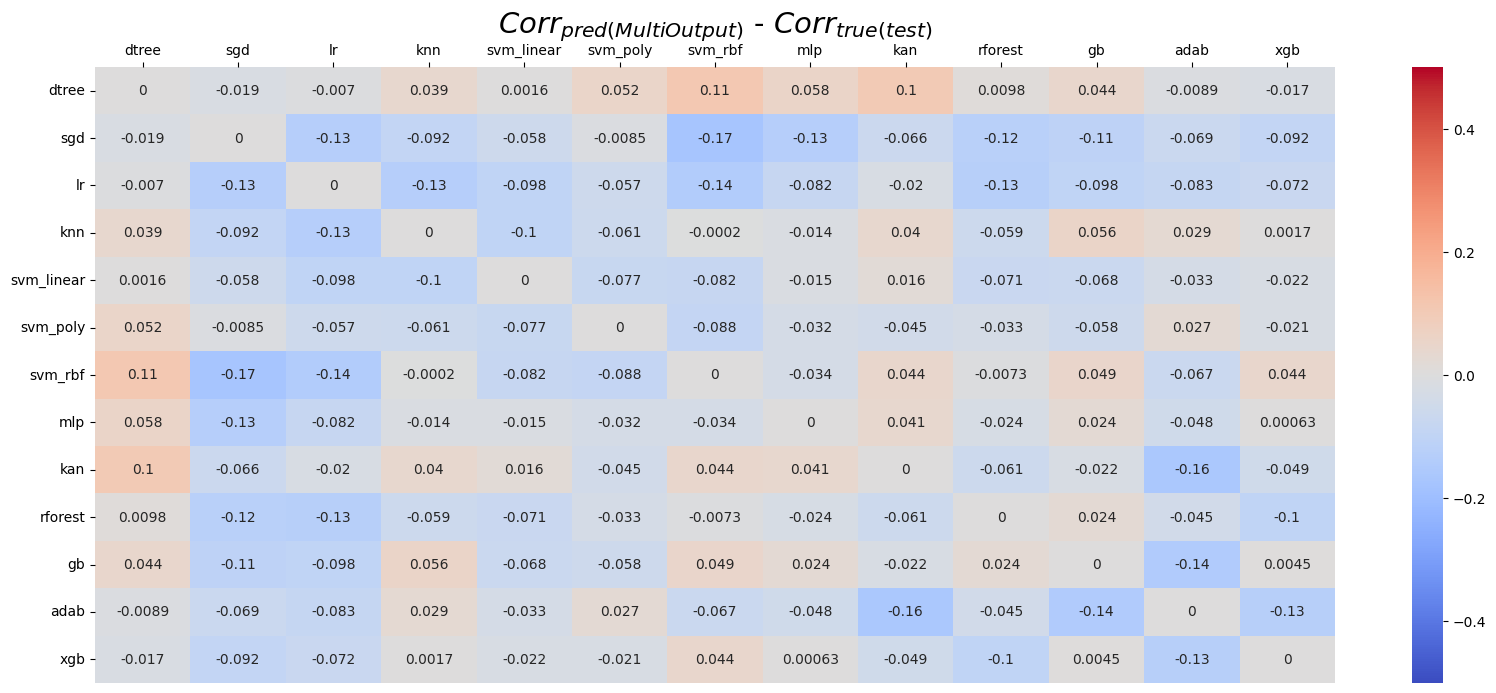

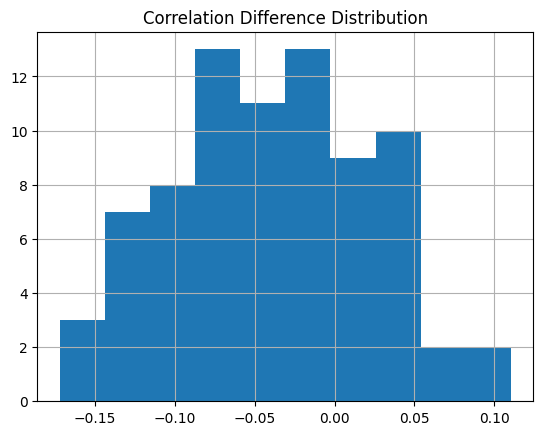

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [133]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'covid')

## Grupais

In [141]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(8) & true_assessor_test(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['lr', 'rforest', 'sgd']
['knn']
['svm_poly']
['svm_rbf']
['kan']
Número de grupos em comum: 7


true_assessor_train(8) & regchain_assessor_train(10):
['dtree']
['knn']
['svm_poly']
['kan']
Número de grupos em comum: 4


true_assessor_train(8) & regchain_assessor_test(10):
['dtree']
['knn']
['svm_poly']
['svm_rbf']
['kan']
Número de grupos em comum: 5


true_assessor_train(8) & mor_assessor_train(11):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['lr', 'rforest', 'sgd']
['knn']
['svm_poly']
['kan']
Número de grupos em comum: 6


true_assessor_train(8) & mor_assessor_test(10):
['dtree']
['knn']
['svm_poly']
['svm_rbf']
['kan']
Número de grupos em comum: 5


true_assessor_train(8) & indv_assessor_train(11):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['lr', 'rforest', 'sgd']
['knn']
['svm_poly']
['kan']
Número de grupos em comum: 6


true_assessor_train(8) & indv_assessor_test(11):
['dtree']
['k

In [142]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'mlp', 'sgd', 'svm_linear']
total: 0.7953326778105541

['lr', 'rforest', 'sgd']
total: 0.745132743362832

['adab', 'gb', 'rforest', 'xgb']
total: 0.6817833292514418



In [143]:
groups['true_assessor_train']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['adab', 'gb', 'rforest', 'xgb']]

In [144]:
groups['true_assessor_test']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['kan'],
 ['adab', 'gb', 'rforest'],
 ['gb', 'rforest', 'xgb']]

### Regressor Chain

In [145]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [146]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0581
RMSE: 0.2252
MAE: 0.1888
NMSE: 0.9772


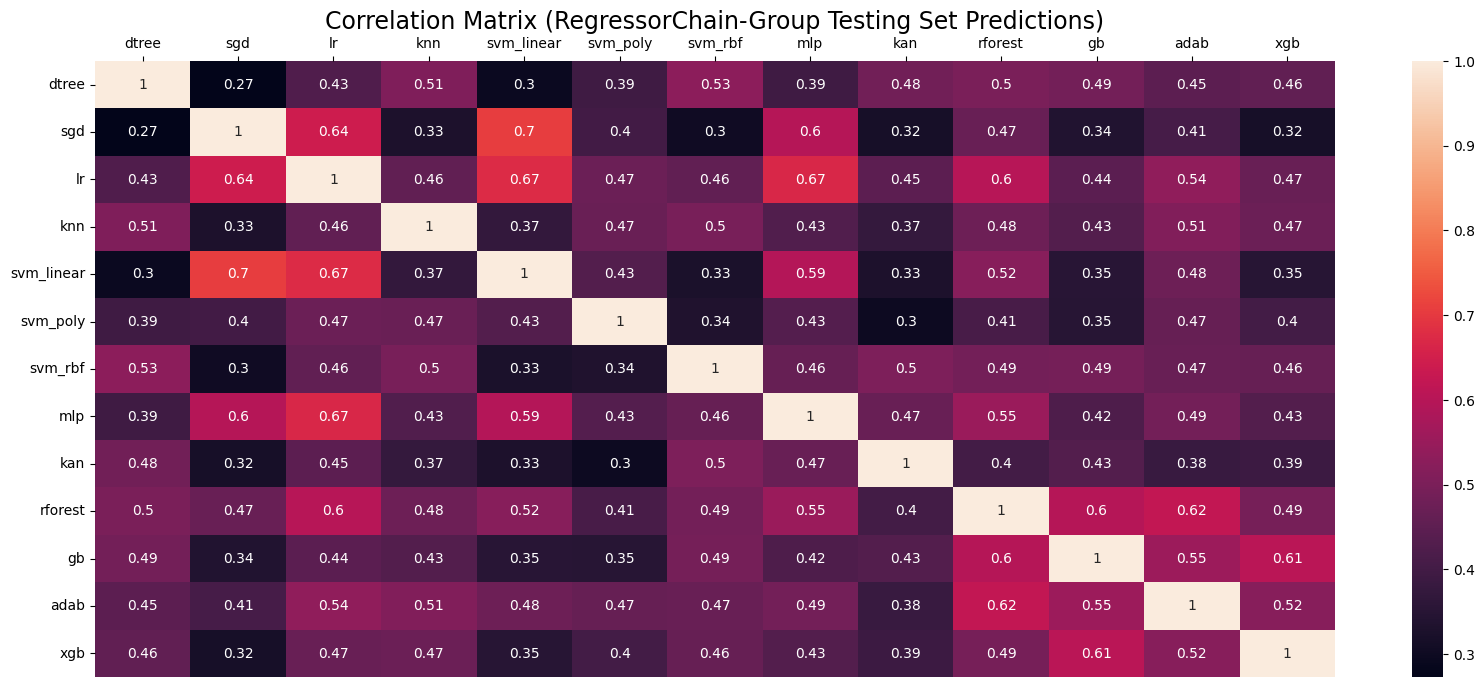

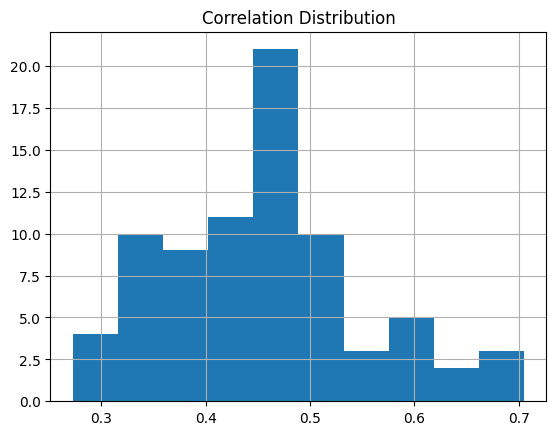

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0163
NMSE: 0.1276
MAE: 0.1064
NMSE: 1.2718
Desvio Padrão: 0.0857


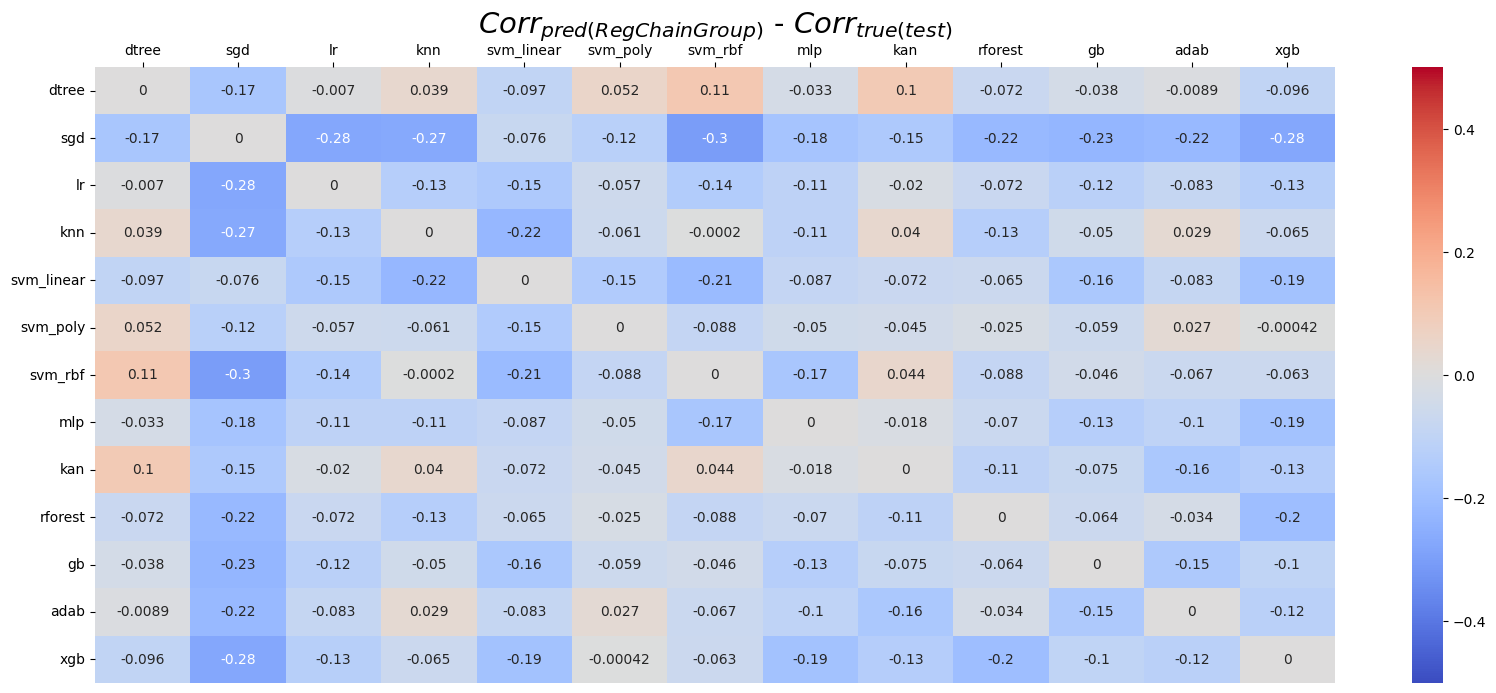

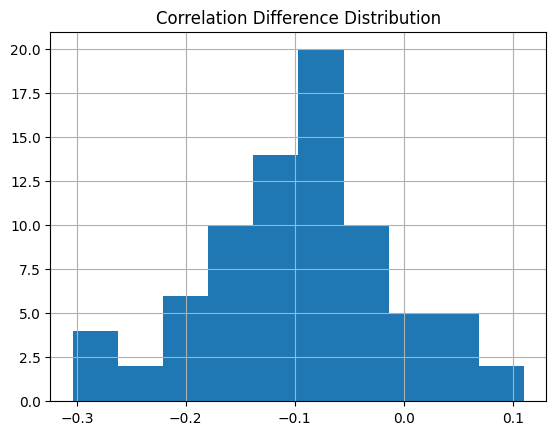

[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [147]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'covid')
save2figs(hm2, hg2, 'covid')

### Multi-Output Regressor

In [ ]:
mrf4groups = []

for g in groups['true_assessor_train']:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train[g])
    mrf4groups.append(model)

In [ ]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mrf4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0572
RMSE: 0.2236
MAE: 0.1873
NMSE: 0.9649


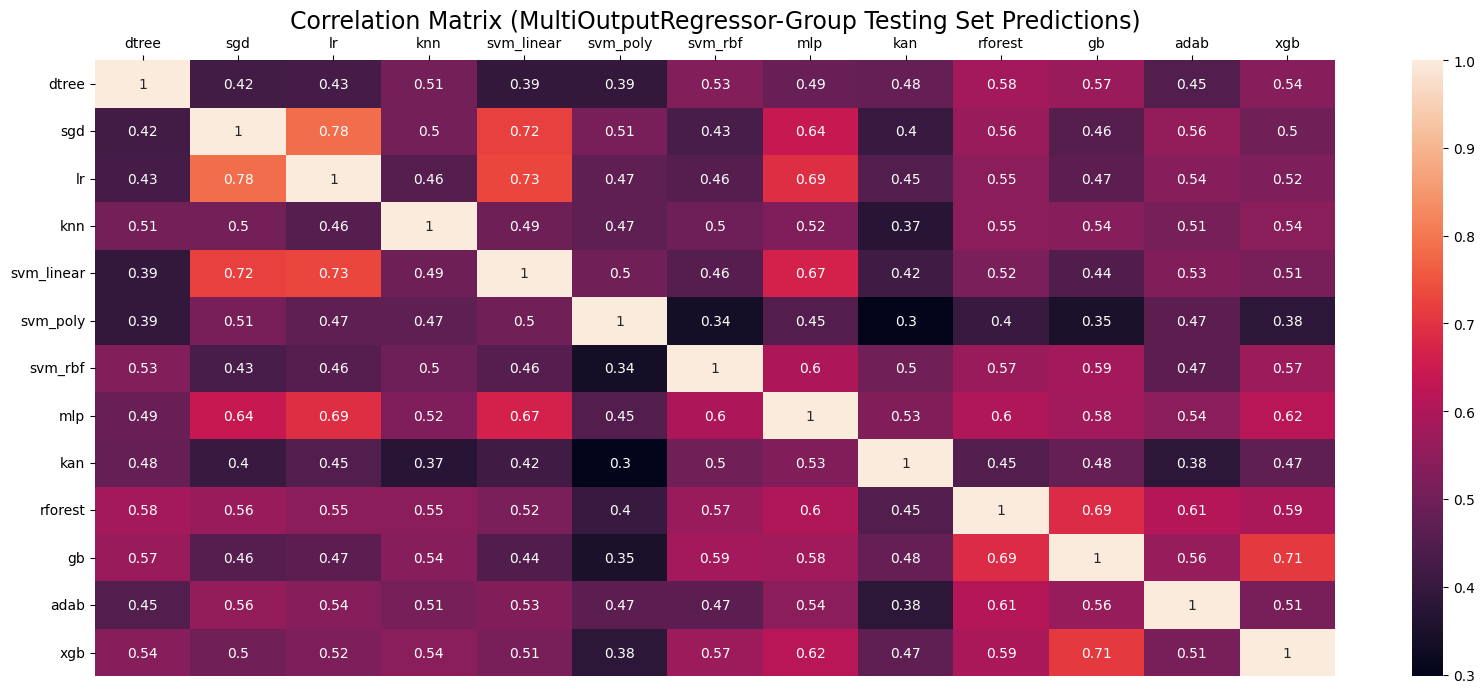

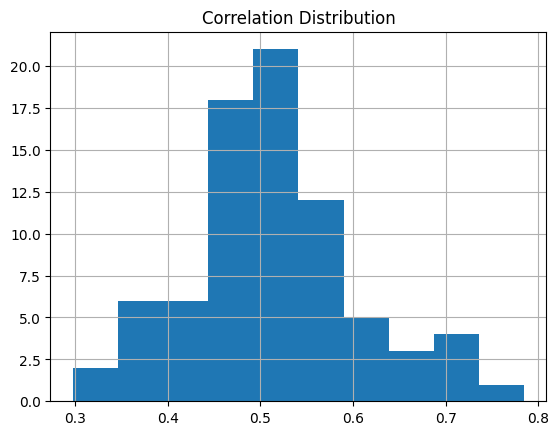

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0053
NMSE: 0.0727
MAE: 0.0590
NMSE: 0.4129
Desvio Padrão: 0.0624


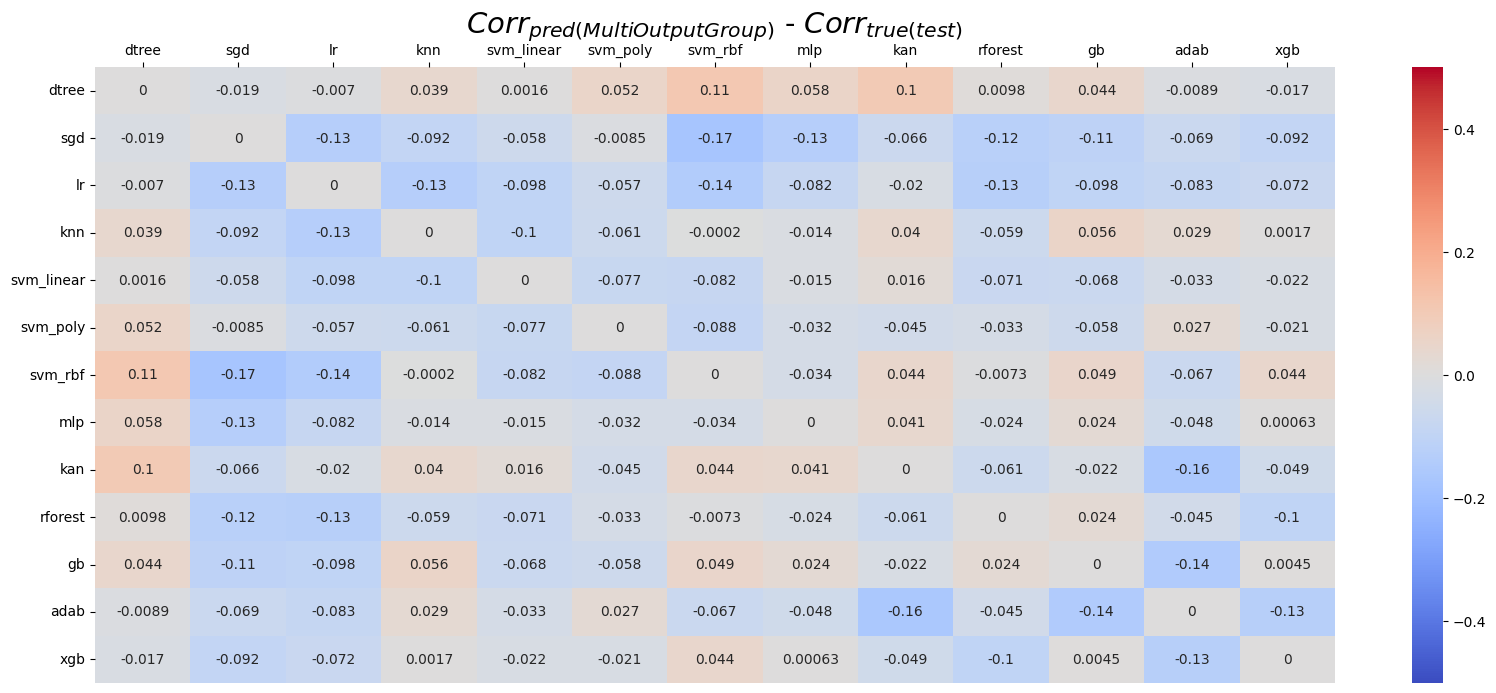

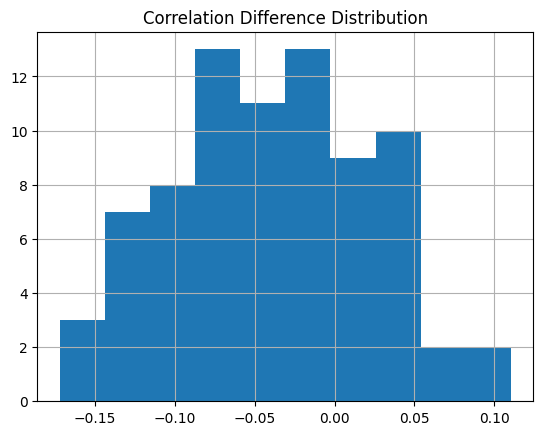

[Saved image "cm_morgtest.eps"]
[Saved image "cd_morgtest.eps"]
[Saved image "cmd_mog.eps"]
[Saved image "cdd_mog.eps"]


In [ ]:
morGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-rforest(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-rforest(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-rforest(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-rforest(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(morGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(morGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandForestGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'churn')
save2figs(hm2, hg2, 'churn')

## Análises

In [151]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.102780  0.320592  0.277700  0.990281
1          multi-output  dtree  0.102780  0.320592  0.277700  0.990281
2            individual  dtree  0.098793  0.314313  0.268420  0.951869
3       regchain(group)  dtree  0.102780  0.320592  0.277700  0.990281
4   multi-output(group)  dtree  0.102780  0.320592  0.277700  0.990281
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.100189  0.316527  0.270673  0.996592
61         multi-output    xgb  0.100638  0.317236  0.270314  1.001059
62           individual    xgb  0.098982  0.314614  0.268541  0.984583
63      regchain(group)    xgb  0.104012  0.322509  0.275618  1.034619
64  multi-output(group)    xgb  0.100638  0.317236  0.270314  1.001059

[65 rows x 6 columns]

In [157]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
teste.to_csv('data/covid/results.csv')
teste

MSE                RMSE                 MAE  \
                         mean       std      mean       std      mean   
assessor_type                                                           
individual           0.056651  0.040566  0.222468  0.088064  0.185835   
multi-output         0.057202  0.040854  0.223567  0.088439  0.187265   
multi-output(group)  0.057202  0.040854  0.223567  0.088439  0.187265   
regchain             0.057715  0.041054  0.224647  0.088618  0.187591   
regchain(group)      0.058062  0.041217  0.225201  0.089208  0.188825   

                                   NMSE            
                          std      mean       std  
assessor_type                                      
individual           0.078515  0.955059  0.075777  
multi-output         0.079895  0.964853  0.072309  
multi-output(group)  0.079895  0.964853  0.072309  
regchain             0.080436  0.975050  0.066871  
regchain(group)      0.080153  0.977173  0.072193

In [153]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

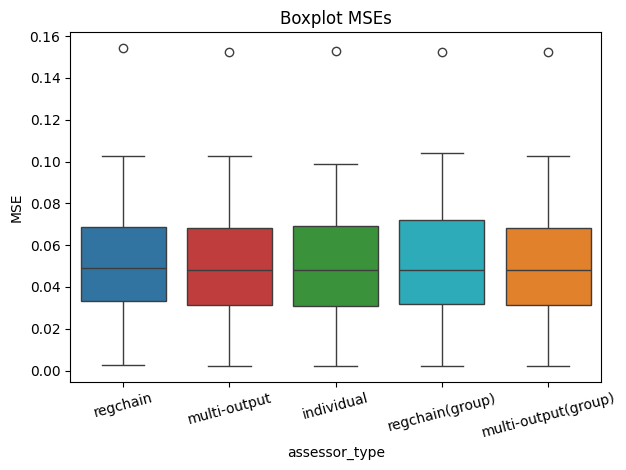

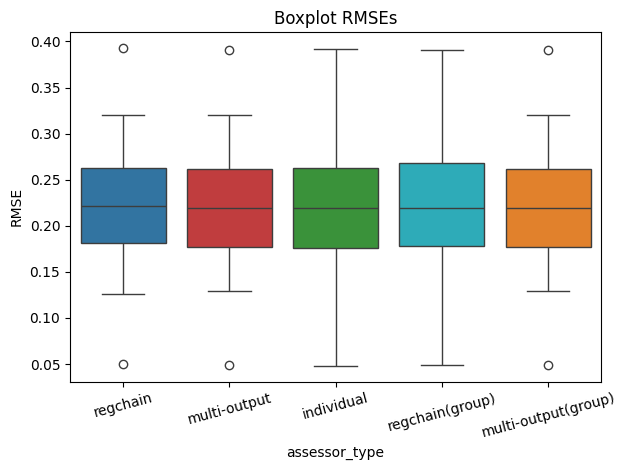

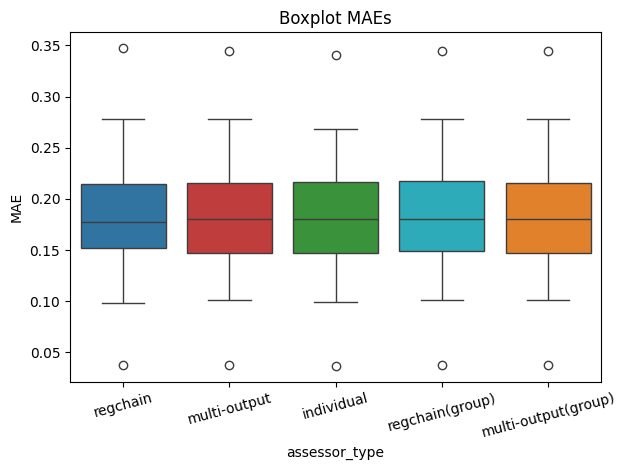

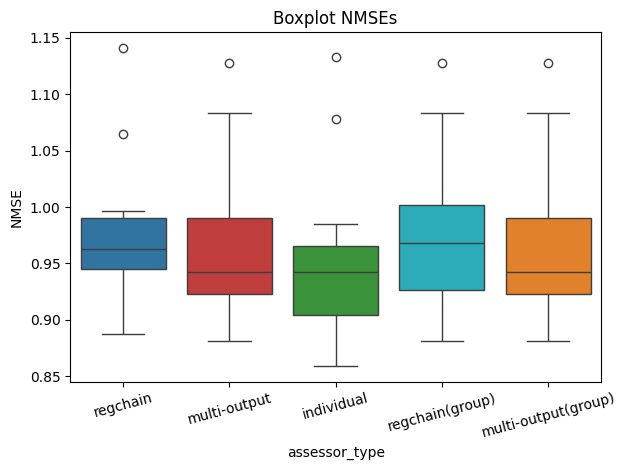

In [154]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/covid/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

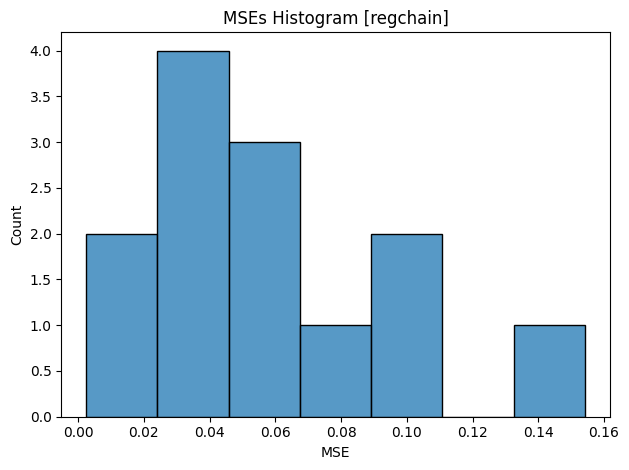

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


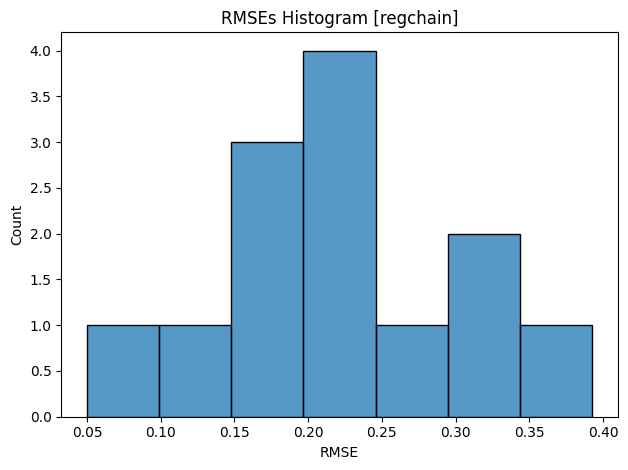

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


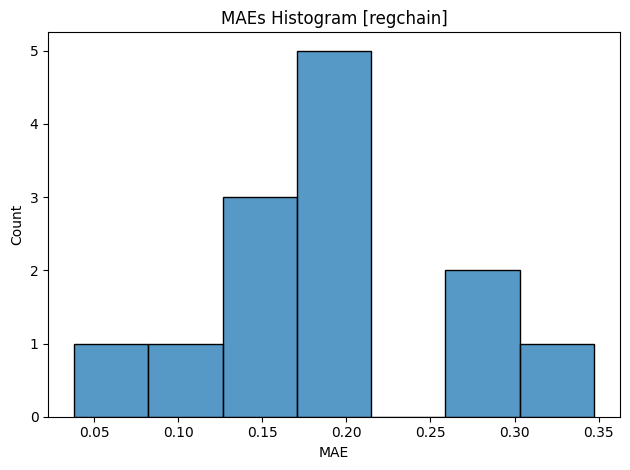

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


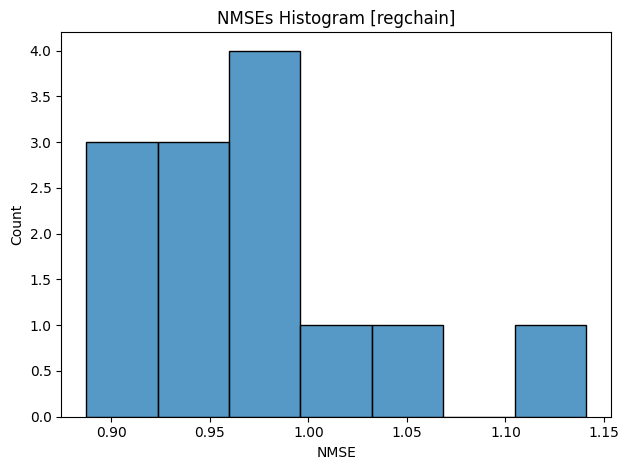

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


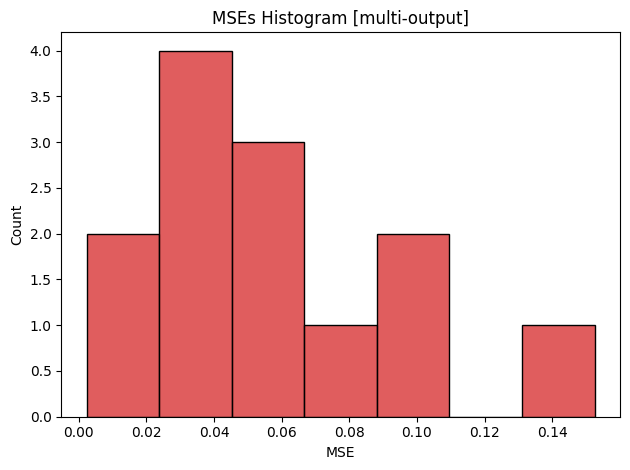

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


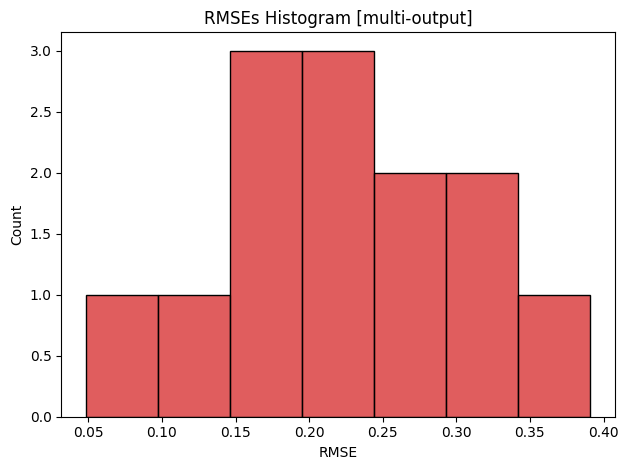

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


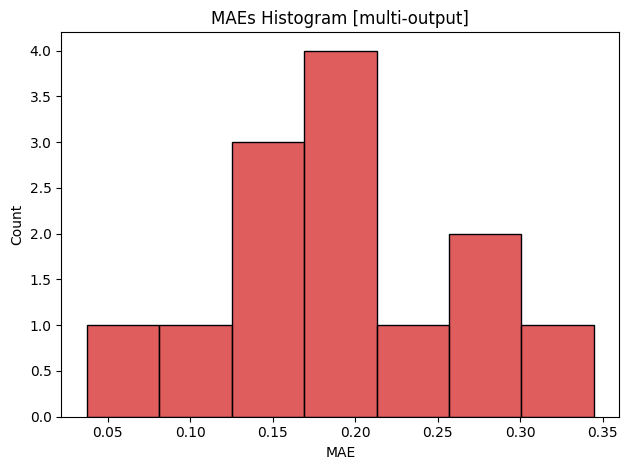

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


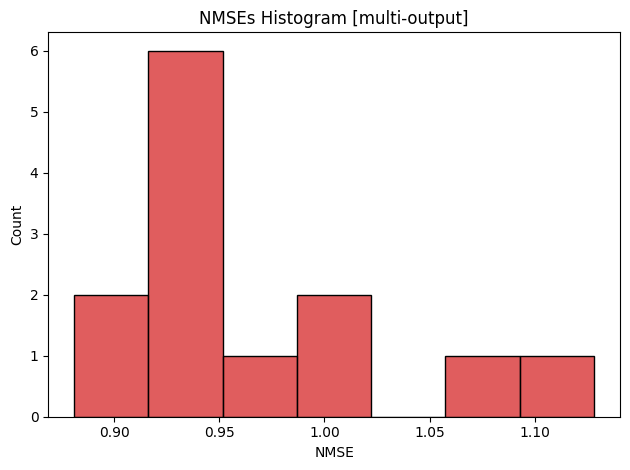

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


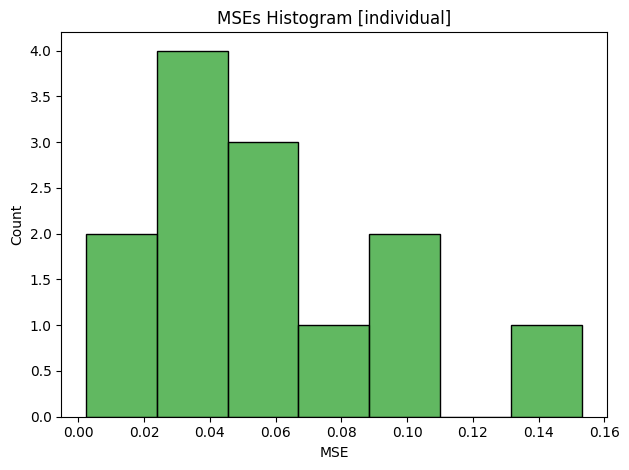

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


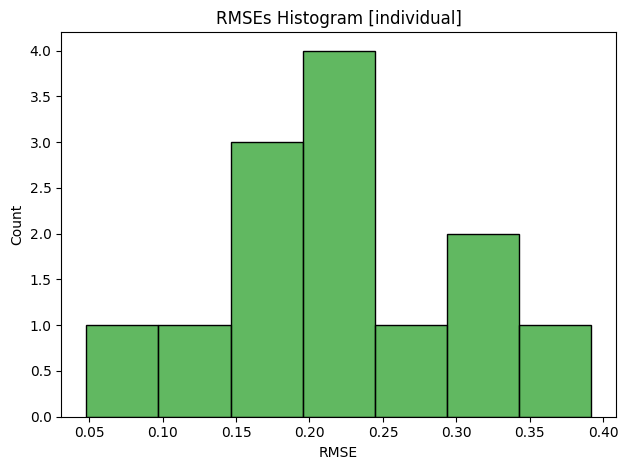

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


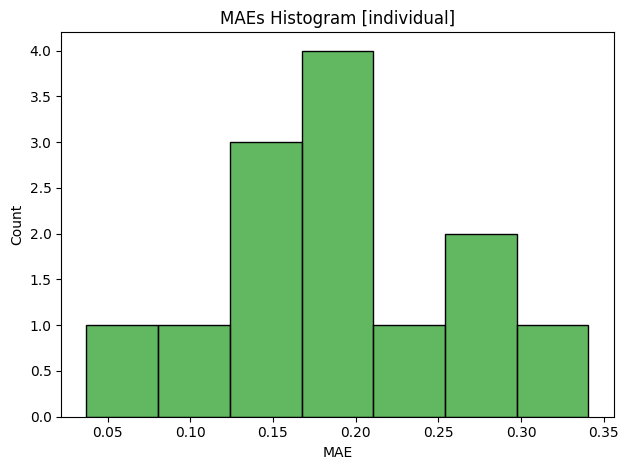

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


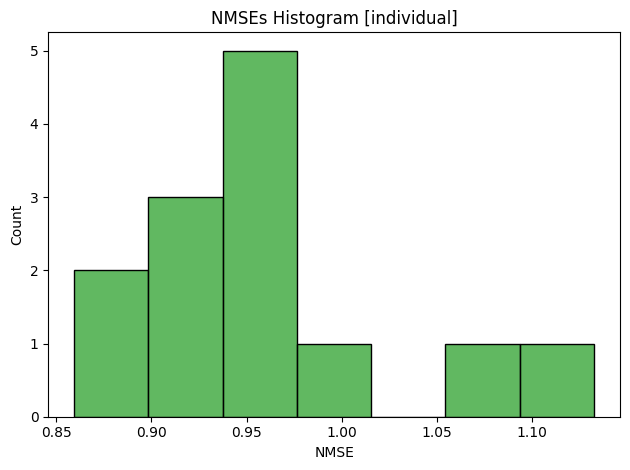

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


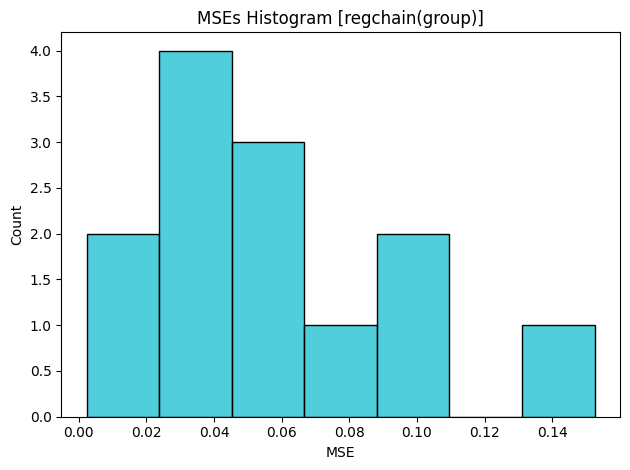

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


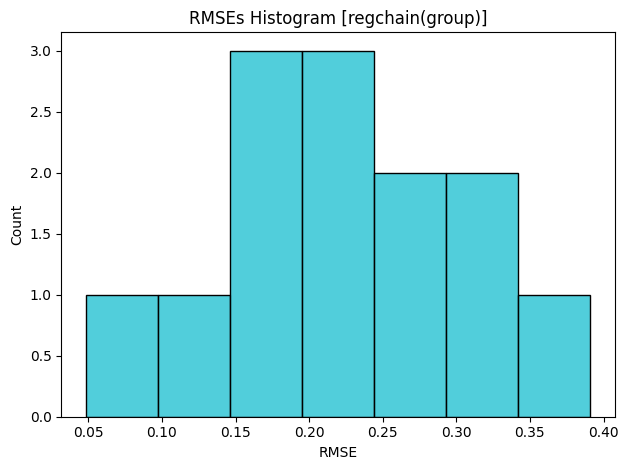

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


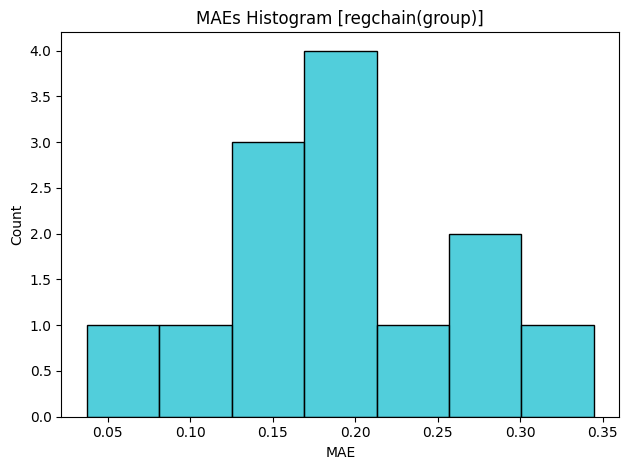

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


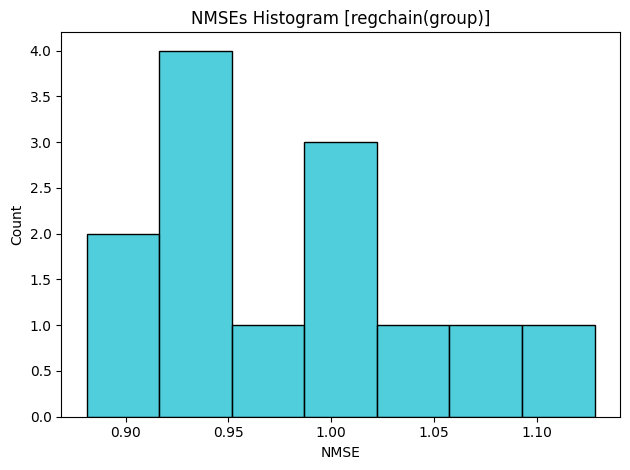

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


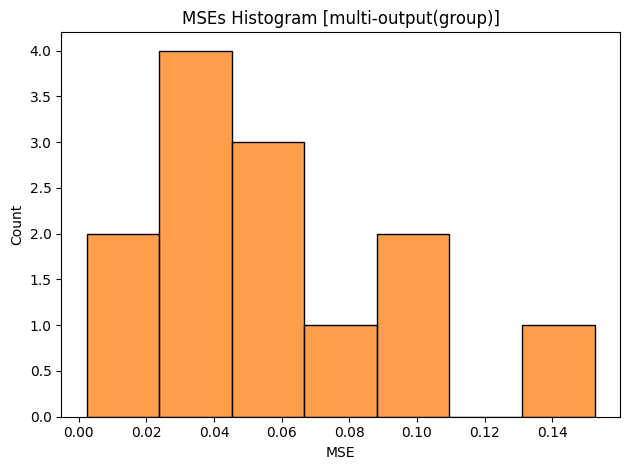

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


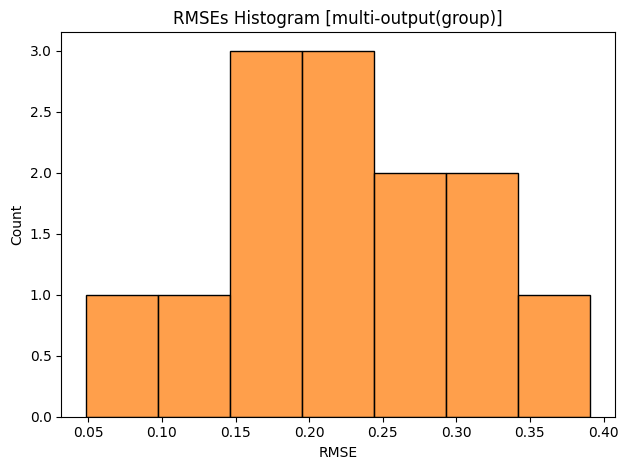

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


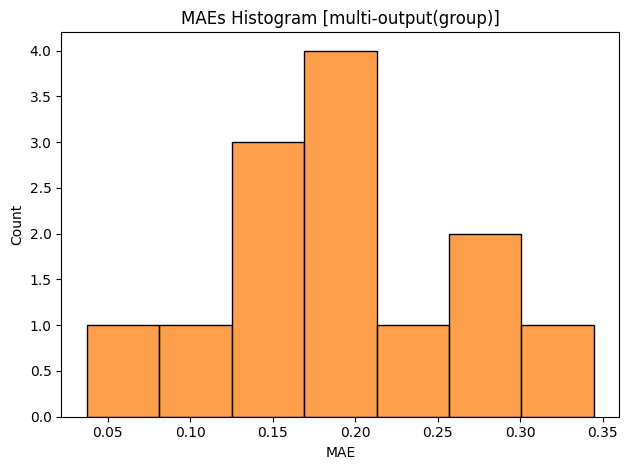

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


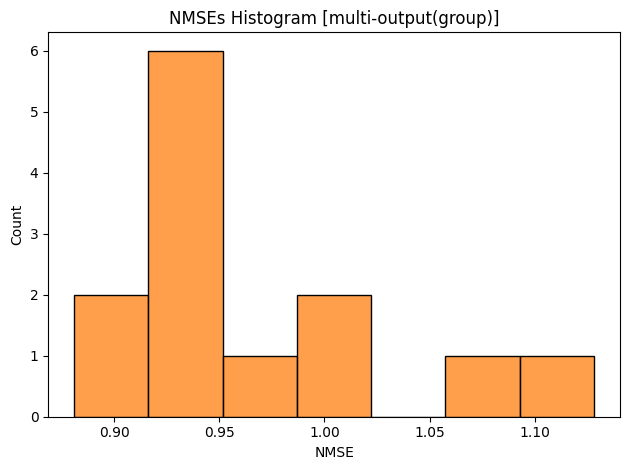

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-forest': {'color': class_palette[1], 'code': 'mrf'},
         'multi-output': {'color': class_palette[2], 'code': 'mor'},
         'regchain(group)': {'color': class_palette[3], 'code': 'rcg'},
         'multi-rforest(group)': {'color': class_palette[4], 'code': 'mrfg'}}

for a in dicio.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/covid/imgs/hg_{dicio[a]['code']}_{mt.lower()}.eps', format='eps', dpi=300)

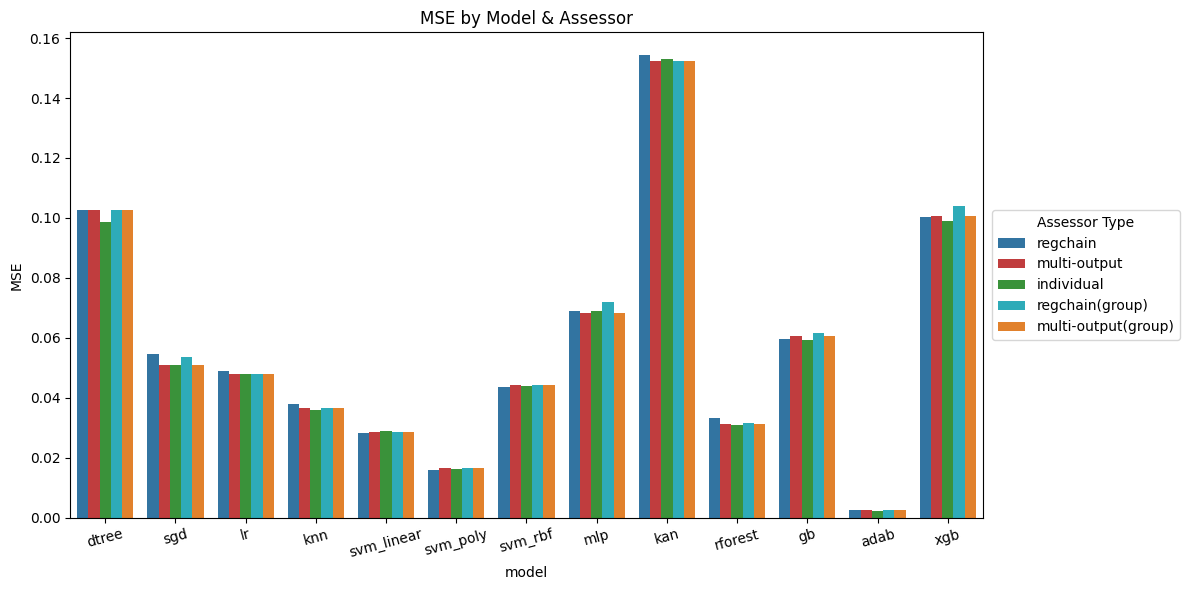

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


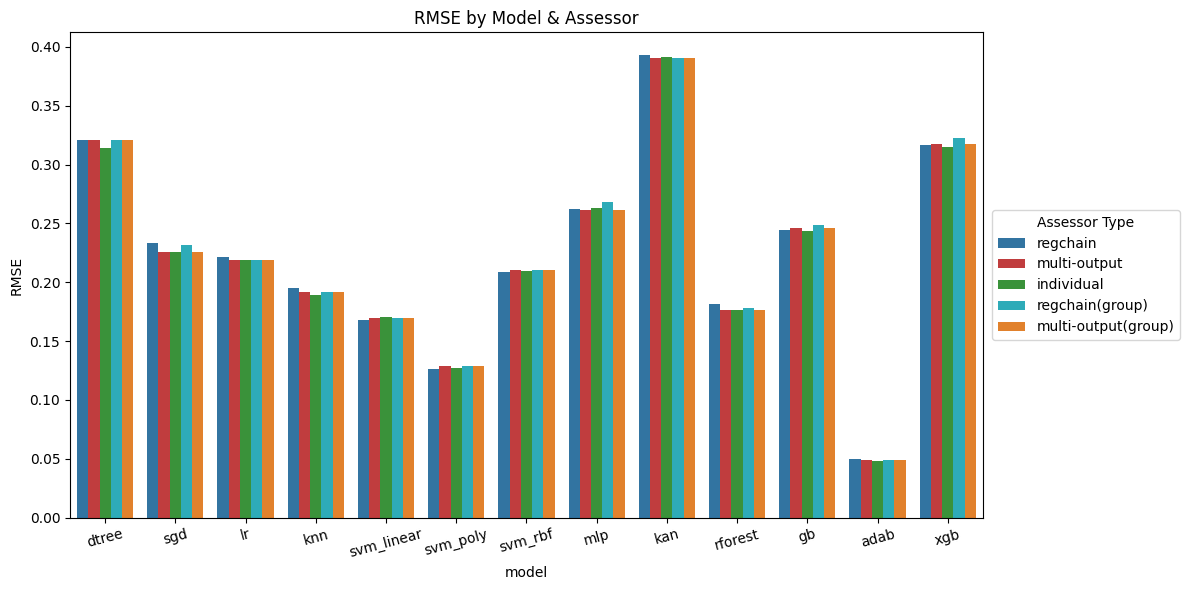

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


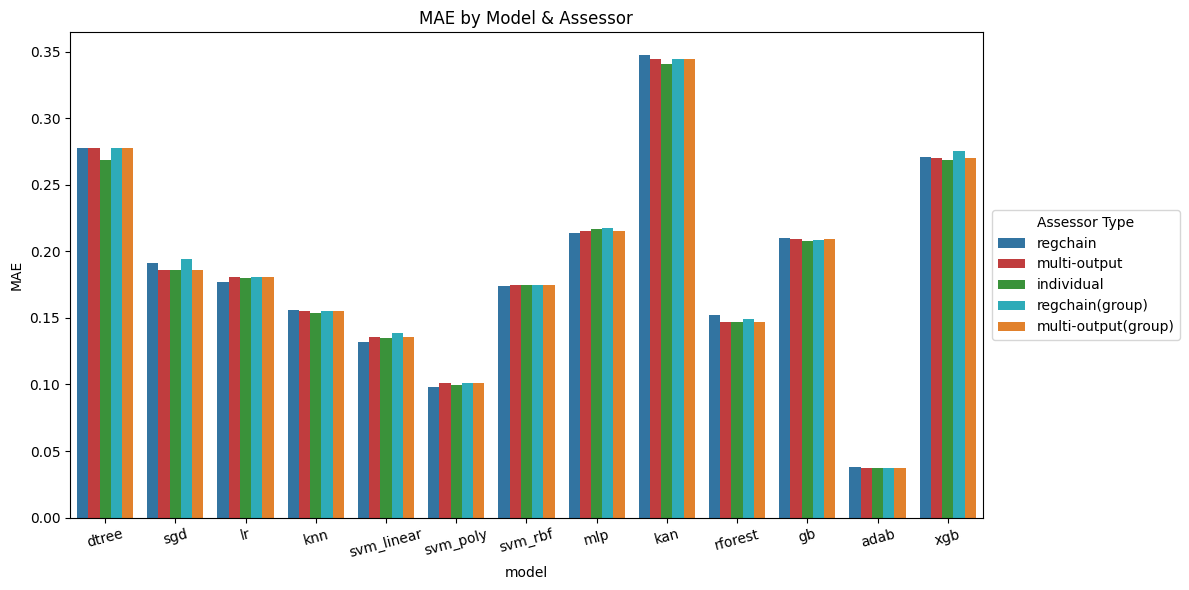

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


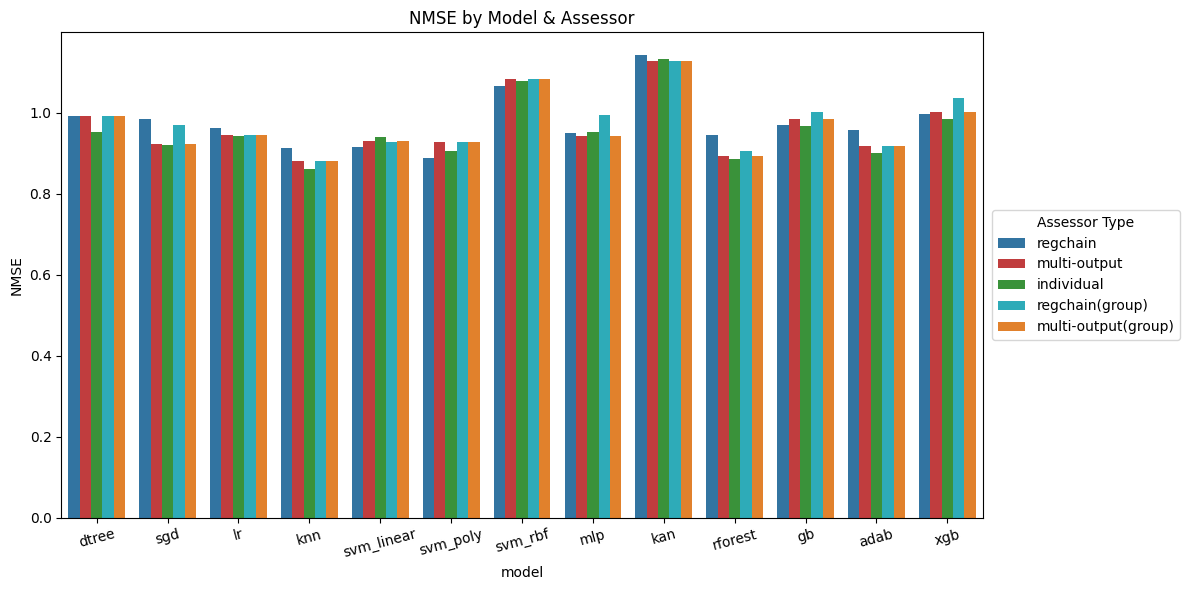

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [156]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/covid/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)